Hello Fellow Kagglers,

This competition has been challenging to say the least, especially the submission.

After a few weeks I finally got a working training + inference pipeline which is shared through this notebook.

The model consists of a transformer embedding + encoder + decoder.

Inference is performed by starting with an Start of Sentence (SOS) token and predicting one character at a time using the previous prediction.

Feel free to ask for clarafications or comment.

Notebook will be updated periodically.

[Preprocessing Notebook](https://www.kaggle.com/code/m4nugnzl/aslfr-eda-preprocessing-dataset-for-beginners)

**V6**

This competition has an inference limit of 5 hours which requires careful allocation of computational resources in the model. Most changes are based on the assymetrical number of encoder/decoder calls during inference.

Inference requires the encoder to encode the input frames and subsequently use that encoding to predict the 1st character by inputting the encoding and Start of Sentence token. Next, the encoding, SOS token and 1st predicted token are used to predict the 2nd character. Inference thus requires 1 call to the encoder and multiple calls to the encoder. On average a phrase is 18 characters long, requiring 18+1(SOS token) calls to the decoder. To stay within the 5 hour inference limit the encoder can be computationally heavy, however the decoder should be light.

Some inspiration is taken from the [1st place solution - training](https://www.kaggle.com/code/hoyso48/1st-place-solution-training) from the last [Google - Isolated Sign Language Recognition
](https://www.kaggle.com/competitions/asl-signs) competition.

* Increased training epochs 30 -> 100
* Using all data for training, no validation set
* Increased number of decoder blocks 2 -> 3
* Increased encoder dimensions 256 -> 384
* Halved attention dimension to decrease computational intensity of Multi Head Attention
* Added 20% dropout to multi head attention output
* Batch size 128 -> 64
* Classification layer linear activation for logits in loss function

**V7**

A small update, since several other notebooks got released with a LB score as high as 0.689!

This will most likely be the last version of this notebook, it seems like the way to get to 0.70 is CTC loss.

The 5 hour inference limit could is limitation with this encoder/decoder architecture.

Performance could be improved by using FlashAttention, however this is not yet implemented in Tensorflow.

Another observation is the huge speedup from jit_compile, which allows for inferencing up to ~30 samples per second. The TFLite model obtains about ~3 samples/s and it seems the `jit_compile` flag does not impact the TFLite model speed.

Modifications in this version

* More efficient transformer architecture based on 1st place solution - training by HOYSO48
* NUM_BLOCKS_ENCODER = 3 → 4
* Correct attention mask in decoder: causal → non empty frames

**Helpful Tutorials**

[English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

[Lecture 12.1 Self-attention](https://www.youtube.com/watch?v=KmAISyVvE1Y&list=LL&index=3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Tensorflow Version 2.12.0
Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


# Character 2 Ordinal Encoding

In [2]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}

# convert dictionary to pandas dataframe
CHAR2ORD_DF = pd.DataFrame(CHAR2ORD.values(),index=CHAR2ORD.keys(),columns=['Ordinal Encoding'])
CHAR2ORD_DF.head()

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4


# Hyperparameters

Definimos los hiperparámetros que vamos a usar posteriormente

- `IS_INTERACTIVE`: Esta variable indica si el cuaderno se está ejecutando en modo interactivo, lo que significa que se está ejecutando en un entorno donde se pueden realizar cambios y experimentar de manera interactiva. En este modo, puedes ejecutar celdas de código individualmente, modificar el código y ver los resultados inmediatamente. Esto es útil cuando estás desarrollando y depurando tu código, ya que te permite realizar cambios rápidos y observar los efectos de esos cambios en tiempo real. **Si lo que se quiere es ejecutar el código completo (5 horas) dejar** `IS_INTERACTIVE=False`. **En caso contrario, comentar esa misma línea de código**

- `SEED`: Esta es una semilla aleatoria global utilizada para reproducir los resultados. Al fijar una semilla, se garantiza que los resultados sean consistentes en diferentes ejecuciones.

- `N_TARGET_FRAMES`: Esta variable indica el número de fotogramas a los que se redimensionarán las grabaciones. Esto se hace para **estandarizar la longitud de las secuencias de entrada**.

- `DEBUG`: Esta variable indica si se está ejecutando en modo de depuración. Si es `True`, se ejecutará en modo de depuración, lo que puede implicar la ejecución de un subconjunto de los datos para una ejecución más rápida y para facilitar la depuración.

- `N_UNIQUE_CHARACTERS0`: Esta variable representa el número de **caracteres únicos que se deben predecir en el modelo**. No incluye el token de padding (relleno), el token de inicio de oración y el token de fin de oración.

- `N_UNIQUE_CHARACTERS`: Esta variable es similar a `N_UNIQUE_CHARACTERS0`, pero incluye el token de relleno, el token de inicio de oración y el token de fin de oración. Por lo tanto, representa el número total de clases que el modelo debe predecir.

- `PAD_TOKEN`, `START_TOKEN` y `END_TOKEN`: Estas variables representan los índices de los tokens de padding, inicio de oración y fin de oración en el vocabulario. Se utilizan durante el procesamiento de los datos y la generación de las secuencias de texto objetivo.

- `USE_VAL`: Esta variable controla si se utiliza el 10% de los datos para la validación durante el entrenamiento.

- `BATCH_SIZE`: Esta variable determina el tamaño del lote para el entrenamiento.

- `N_EPOCHS`: Esta variable establece el número de épocas para entrenar el modelo. Si `IS_INTERACTIVE` es True, se establece en 2 para un entrenamiento rápido en modo interactivo; de lo contrario, se establece en 100 para un entrenamiento normal.

- `N_WARMUP_EPOCHS`: Esta variable define el número de épocas de calentamiento en el programador de la tasa de aprendizaje.

- `LR_MAX`: Esta variable establece la tasa de aprendizaje máxima para el proceso de entrenamiento.

- `WD_RATIO`: Esta variable representa el ratio de decaimiento de peso en función de la tasa de aprendizaje.

- `MAX_PHRASE_LENGTH`: Esta variable define la longitud máxima de una frase, incluyendo el token de fin de frase.

- `TRAIN_MODEL`: Esta variable controla si se entrena el modelo.

- `LOAD_WEIGHTS`: Esta variable controla si se cargan pesos preentrenados para el modelo.

- `WARMUP_METHOD`: Esta variable especifica el método de calentamiento para el programador de la tasa de aprendizaje, ya sea 'log' o 'exp'.  Si es 'log', la tasa de aprendizaje se aumenta gradualmente de manera logarítmica durante las primeras épocas de calentamiento. Esto significa que al principio se incrementa lentamente y luego se acelera a medida que avanzan las épocas de calentamiento. Es útil cuando se desea un calentamiento más suave y gradual. Si es 'exp', la tasa de aprendizaje se aumenta exponencialmente durante las primeras épocas de calentamiento. Esto implica un aumento más rápido al principio y una tasa de aprendizaje más alta en las primeras épocas. Es útil cuando se quiere un calentamiento más rápido y agresivo.

Tal y como lo tenemos ahora, el notebook se ejecuta en modo interactivo, con verbosidad 1, sin subset de entrenamiento ni conjunto de validación (usaremos todo para entrenar). Utilizaremos una configuración que permita una rápida ejecución, con un número de épocas de 2.

In [3]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
#IS_INTERACTIVE = False # to run full code
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1
PAD_TOKEN = len(CHAR2ORD) # Padding # 59
START_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence # 60
END_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence # 61
# Whether to use 10% of data for validation
USE_VAL = False
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 2 if IS_INTERACTIVE else 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'

# Read an Prepare the Data

# Read Train

Como `DEBUG=False`, cargamos el conjunto de entrenamiento entero. Le añadimos una columna `file_path`, con la dirección o ruta completa de los archivos tipo parquet.

In [4]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# this will be used to construct TFLite model
train_sequence_id = train.set_index('sequence_id')

# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

train.head()

,path,file_id,sequence_id,participant_id,phrase,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,/kaggle/input/asl-fingerspelling/train_landmar...


## Example File Paths

Cargamos ahora los 10 elementos parquet que habíamos guardado en `train_landmark_subsets`

In [5]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input//aslfr-eda-preprocessing-dataset-for-beginners/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


# Example Parquet

Recordemos la forma que tiene un archivo parquet de los que hemos guardado previo a preprocesarlo:

In [6]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'Number of Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

Number of Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


## Load X/y

De igual forma, cargamos los ficheros de entrenamiento y validación. En nuestro caso, `USE_VAL=False`, por lo que cargamos `X` e `y` completas. La forma original de los ficheros `y` es de `[61955,128]`, debido al relleno que hemos hecho. Como hemos elegido como límite para la frase `31+1` espacios, siendo el último el token de fin de sentencia, restrignimos el tamaño de 128 a 32.

In [7]:
# Train/Validation
if USE_VAL:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/X_train.npy')
    y_train = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/X_val.npy')
    y_val = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {X_train.shape}, y_val shape: {X_val.shape}')
    
# Train On All Data
else:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/X.npy')
    y_train = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')

X_train shape: (61955, 128, 164)
y_train shape: (61955, 32)


# Example Batch

Ahora, creamos ejemplos de lotes (batches) con el fin de depurar (debugging) o probar el funcionamiento del código. Creamos dos conjuntos de ejemplos: uno con un tamaño de muestra más grande (`N_EXAMPLE_BATCH_SAMPLES`) y otro con un tamaño de muestra más pequeño (`N_EXAMPLE_BATCH_SAMPLES_SMALL`).

En cada conjunto de ejemplos, creamos un diccionario `X_batch` que contiene las características de entrada y un array `y_batch` que contiene las etiquetas de salida.

En el diccionario `X_batch`, copiamos las primeras `N_EXAMPLE_BATCH_SAMPLES` muestras entrenamiento `X_train`. El valor `frames` representa los datos de los cuadros (frames, en este caso filas, siendo casa fila un conjunto de `[1,128,164]`) y phrase representa las frases asociadas a los frames.

En el array `y_batch`, copiamos las primeras `N_EXAMPLE_BATCH_SAMPLES` etiquetas de entrenamiento `y_train`, que corresponden a las frases asociadas a los frames.

Realizamos el mismo procedimiento para el conjunto más pequeño, utilizando las variables `X_batch_small` e `y_batch_small`.

In [8]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

In [9]:
print("Primer elemento de frames:", X_batch_small['frames'][0])
print(f'Shape de cada elemento frames: {X_batch_small["frames"][0].shape} \n\n')
print("Primer elemento de phrase:", X_batch_small['phrase'][0])
print(f'Shape de cada elemento phrase: {X_batch_small["phrase"][0].shape}')

Primer elemento de frames: [[0.         0.         0.         ... 0.549351   0.53822994 0.54001456]
 [0.         0.         0.         ... 0.548015   0.53830063 0.5399543 ]
 [0.         0.         0.         ... 0.5492628  0.53790134 0.5397798 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Shape de cada elemento frames: (128, 164) 


Primer elemento de phrase: [18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]
Shape de cada elemento phrase: (32,)


# Landmark Indices

De igual forma que en el notebook de preprocesamiento, definimos la función `get_idxs` para obtener los índices de las manos izquierda derecha y los labios.

In [10]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [11]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [12]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [13]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

print(f'HAND_X_NAMES: {HAND_X_NAMES}')

HAND_X_NAMES: ['x_left_hand_0' 'x_left_hand_1' 'x_left_hand_2' 'x_left_hand_3'
 'x_left_hand_4' 'x_left_hand_5' 'x_left_hand_6' 'x_left_hand_7'
 'x_left_hand_8' 'x_left_hand_9' 'x_left_hand_10' 'x_left_hand_11'
 'x_left_hand_12' 'x_left_hand_13' 'x_left_hand_14' 'x_left_hand_15'
 'x_left_hand_16' 'x_left_hand_17' 'x_left_hand_18' 'x_left_hand_19'
 'x_left_hand_20']


# Mean/STD Loading

Cargamos la media y la desviación estándar de la media de aquellos valores que eran distintos de 0.

In [14]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-eda-preprocessing-dataset-for-beginners/STDS.npy').reshape(-1)

print(f'First 5 values of MEANS: {MEANS[:5]}')
print(f'Shape of MEANS: {MEANS.shape}') # 164 values, 1 for every column

First 5 values of MEANS: [0.69352776 0.60659605 0.53412515 0.4970676  0.48584947]
Shape of MEANS: (164,)


Añadimos la capa de preprocesamiento de nuevo aquí, ya que la usaremos en el modelo de `TFLite`

In [15]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

# Train Dataset

Ahora, pasamos a crear el dataset de train  a través de la función `get_train_dataset`, que recibe como argumentos las variables `X`, `y` y el tamaño del lote o batch.

- Dentro de la función, se crea un array llamado `sample_idxs` que contiene los índices de las muestras en el conjunto de datos.
- Luego, se crea un bucle infinito con la sentencia `while True`, que permite iterar continuamente sobre el conjunto de datos en lotes.
- En cada iteración, se obtienen índices aleatorios a partir de `sample_idxs` utilizando la función `np.random.choice`. Se seleccionan `batch_size` índices aleatorios sin reemplazo.
- A continuación, se crean dos diccionarios: `inputs` y `outputs`. En `inputs`, se asignan los lotes de frames y phrase correspondientes a los índices aleatorios seleccionados. En `outputs`, se asigna el lote de `y` correspondiente a los índices aleatorios.
- Por último, se utiliza la sentencia `yield` para devolver los diccionarios `inputs` y `outputs` como un par de valores en cada iteración del generador.

De esta manera, al llamar a la función `get_train_dataset` se obtiene un generador que puede ser utilizado en un bucle `for` para iterar sobre los lotes de entrenamiento en cada época de entrenamiento. Cada lote contiene los datos de entrada y salida correspondientes a los índices aleatorios seleccionados.

En el contexto del **entrenamiento de un modelo**, el generador de datos se utiliza para proporcionar lotes de muestras de entrenamiento de manera eficiente durante el proceso de entrenamiento.

El generador de datos se utiliza como el valor de x en el método `fit()` del modelo. En lugar de pasar todos los datos de entrenamiento directamente como un tensor grande, que podría ocupar mucha memoria y ser ineficiente, se utiliza un generador de datos para proporcionar lotes de muestras más pequeños en cada paso de entrenamiento.

La función `get_train_dataset` devuelve un generador infinito que, en cada iteración, toma un lote aleatorio de muestras de entrenamiento (`batch_size`) a partir del conjunto de datos de entrenamiento X e y. Cada lote de muestras es un diccionario con dos claves: 'frames' y 'phrase'. Los datos de entrada se encuentran en la clave 'frames', que contiene las secuencias de datos numéricos correspondientes a las "frames" (secuencias de entrada de datos). Los datos de salida (etiquetas) se encuentran en la clave 'phrase', que contiene las secuencias de índices enteros que representan las "frases" (secuencias de salida deseada).

Cuando el método fit() del modelo recibe este generador de datos (train_dataset) como x, se ejecuta en cada época de entrenamiento y toma lotes de muestras del generador para actualizar los pesos del modelo. Esto permite entrenar el modelo utilizando todos los datos de entrenamiento, pero sin cargarlos todos en la memoria al mismo tiempo, lo que es útil para conjuntos de datos grandes. El generador continuará proporcionando lotes de muestras indefinidamente durante el entrenamiento, lo que asegura que el modelo se entrene en todas las muestras de entrenamiento disponibles.

In [16]:
# Train Dataset Iterator
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [17]:
# Train Dataset
train_dataset = get_train_dataset(X_train, y_train)

train_dataset

<generator object get_train_dataset at 0x7e7ab58447b0>

In [18]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 969


# Validation Dataset

Hcaemos lo mismo para el set de validación

In [19]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [20]:
# Validation Dataset
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

In [21]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

# Model Config

Previo al proceso de modelizado, comentaremos en qué consiste un modelo de tipo transformer:

A diferencia de las arquitecturas recurrentes tradicionales como las redes neuronales recurrentes (RNN) o las redes neuronales convolucionales (CNN), que se basan en conexiones recurrentes o convoluciones para capturar dependencias temporales en los datos secuenciales, el modelo Transformer se basa en mecanismos de atención para capturar estas dependencias. El enfoque principal del mecanismo de atención es calcular las relaciones entre todos los elementos de una secuencia para asignar ponderaciones o importancias a cada elemento en función de su relevancia para la tarea en cuestión.

El modelo Transformer consta de dos componentes principales: el codificador y el decodificador. Cada componente está compuesto por múltiples capas apiladas. El codificador se encarga de procesar la entrada de texto original y capturar información relevante de cada palabra o token en la secuencia. Este proceso se realiza mediante mecanismos de atención, que permiten al modelo focalizarse en las partes más importantes de la entrada en cada paso. En el codificador, se aplican capas de atención multi-cabezal y capas de redes neuronales completamente conectadas para capturar y procesar la información contextual de la entrada.

Por otro lado, el decodificador se encarga de generar la salida deseada, como la traducción de la entrada original a otro idioma. El decodificador también utiliza mecanismos de atención, pero en este caso, se enfoca tanto en la entrada original (a través de la atención enmascarada) como en la salida generada hasta el momento. Esto permite al modelo generar palabras o tokens de salida basados en el contexto actual y las palabras generadas anteriormente.

En cada capa tanto del codificador como del decodificador, se aplican técnicas de normalización y regularización, como la normalización de capa y el dropout, para estabilizar y regularizar el proceso de aprendizaje. Estas técnicas ayudan a mejorar la generalización del modelo y prevenir el sobreajuste.

En resumen, el codificador procesa la entrada original y captura la información contextual utilizando mecanismos de atención, mientras que el decodificador utiliza la información del codificador y las salidas generadas hasta el momento para producir la salida deseada.

Procedemos ahora a definir varias variables relacionadas con la arquitectura y configuración de un modelo Transformer. 

- `LAYER_NORM_EPS` : Representa el valor epsilon utilizado en la capa de normalización del modelo Transformer.
- `UNITS_ENCODER` y `UNITS_DECODER`: Estas variables indican el tamaño de la salida final y de los embeddings del codificador y decodificador respectivamente.
- `NUM_BLOCKS_ENCODER` y `NUM_BLOCKS_DECODER`: Representan el número de bloques (capas) en el codificador y decodificador del Transformer.
- `NUM_HEADS`: Indica el número de cabezas de atención en el mecanismo de atención multi-cabeza del Transformer.
- `MLP_RATIO`: Es el factor de multiplicación utilizado para calcular el tamaño de la capa de feed-forward en el bloque del Transformer.
- `EMBEDDING_DROPOUT`, `MLP_DROPOUT_RATIO`, `MHA_DROPOUT_RATIO` y `CLASSIFIER_DROPOUT_RATIO`: Estas variables definen las tasas de dropout utilizadas en diferentes partes del modelo, como la capa de embedding, la capa de feed-forward y la capa clasificadora.
- `INIT_HE_UNIFORM`, `INIT_GLOROT_UNIFORM` y `INIT_ZEROS`: Son inicializadores utilizados para inicializar los pesos de las capas del modelo. `INIT_HE_UNIFORM` utiliza la inicialización He Uniform, `INIT_GLOROT_UNIFORM` utiliza la inicialización Glorot Uniform e `INIT_ZEROS` inicializa los pesos con ceros.
- `GELU`: Es una función de activación llamada GELU (Gaussian Error Linear Unit) utilizada en el modelo.

In [22]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 4
NUM_BLOCKS_DECODER = 3
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Landmark Embedding


En este paso, definiremos una clase llamada `LandmarkEmbedding` que hereda de `tf.keras.Model` y se utiliza para realizar el embedding de un landmark utilizando capas completamente conectadas. El embedding de un landmark, se refiere a la transformación de una representación de coordenadas (landmarks), en un vector resultado de aplicar transformaciones no lineales y aprender representaciones más expresivas de los landmarks. Estas representaciones embebidas pueden capturar características importantes de los landmarks, como su posición relativa, forma o cualquier otra información relevante para la tarea en cuestión...

La clase `LandmarkEmbedding` tiene los siguientes componentes:

- El método `__init__` se encarga de inicializar la clase y configurar sus atributos. Recibe dos parámetros: `units`, que representa la dimensión de la incrustación, y `name`, que es el nombre de la incrustación.
- El método `build` se utiliza para construir la arquitectura del modelo. Recibe el `input_shape` que define la forma de los datos de entrada. En este caso, se construye una incrustación para los landmarks. 
    * Dentro del método `build`, se define un peso llamado `empty_embedding` utilizando `self.add_weight`. Este peso representa la incrustación para un landmark faltante en un frame y se inicializa con ceros.
    * A continuación, se define una secuencia de capas densas utilizando `tf.keras.Sequential`. Estas capas se utilizan para realizar la incrustación de los landmarks. La primera capa densa tiene `units` unidades y utiliza la función de activación GELU (Gaussian Error Linear Unit). La segunda capa densa también tiene `units` unidades y se inicializa con el método He Uniform.
- El método `call` es la función de llamada del modelo y se utiliza para realizar la incrustación de los datos de entrada `x`. En esta función, se utiliza`tf.where` para aplicar una condición. Si la suma de los landmarks en un frame es igual a cero, lo que significa que el landmark es nulo, se utiliza la incrustación vacía `empty_embedding`. De lo contrario, se utiliza la incrustación de los datos de landmark utilizando la secuencia de capas densas definida anteriormente.

In [23]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initialized with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,)
        # Embedding: 2 dense layers
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        # if the landmark = 0 -> use empty embedding (return 0s), else use dense embedding
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

> Ejemplo : Definimos los landmarks de tres frames utilizando tensores constantes de TensorFlow. Cada frame tiene dos landmarks representados como pares de coordenadas `(x, y)`. Pasamos los landmarks por el modelo de embedding utilizando la función `call()` del modelo. Esto generará las representaciones embebidas de los landmarks. En cada print, se verán las representaciones embebidas de los landmarks en forma de tensores. Cada tensor tendrá la forma `(n_batch,num_landmarks, num_dimensions)`, donde `num_landmarks` es el número de landmarks en el frame y `num_dimensions` es el número de dimensiones de cada landmark (en este caso, 2 para las coordenadas x e y).

In [24]:
# Create an instance of the LandmarkEmbedding model
embedding_model = LandmarkEmbedding(units=2, name='landmark')

# Define the landmarks of the three frames
frame_1 = tf.constant([[[1, 2], [3, 4]]])
frame_2 = tf.constant([[[0, 0], [5, 6]], [[7, 8], [9, 10]]])

# Pass the landmarks through the embedding model
embedding_1 = embedding_model(frame_1)
embedding_2 = embedding_model(frame_2)

# Print the embedded representations of the landmarks
print(f'Frame 1 shape: {frame_1.shape} ')
print("Frame 1 embeddings:")
print(embedding_1)

print("\n\nFrame 2 embeddings:")
print(embedding_2)

Frame 1 shape: (1, 2, 2) 
Frame 1 embeddings:
tf.Tensor(
[[[3.1116607 2.957823 ]
  [6.569265  6.1657634]]], shape=(1, 2, 2), dtype=float32)


Frame 2 embeddings:
tf.Tensor(
[[[ 0.        0.      ]
  [ 9.981428  9.362338]]

 [[13.389832 12.559214]
  [16.798143 15.756097]]], shape=(2, 2, 2), dtype=float32)


> **Output**: En la salida del primer frame , se muestra un tensor de forma `(1, 2, 2)` y tipo de dato *float32*. Esto significa que hay una sola muestra en el batch, dos landmarks en el frame (dos vectores) y dos dimensiones para cada landmark (x,y).
Cada valor en el tensor representa la representación embebida de un landmark en el frame. Por ejemplo, el primer valor `[0.00237609, -0.14469941]` corresponde a la representación embebida del primer landmark `[1,2]`, y el segundo valor `[0.00064886, -0.10494988]` corresponde a la representación embebida del segundo landmark.

 El modelo LandmarkEmbedding realiza una transformación de los valores originales de los landmarks utilizando las capas densas definidas en el método build.

- Si el valor de un landmark es igual a cero, lo que indica que el landmark está faltante en el frame, se utiliza una incrustación vacía (representada por `self.empty_embedding`) en lugar de realizar la transformación.
- Si el valor de un landmark es distinto de cero, se aplica la transformación utilizando las capas densas (`self.dense`). En este caso, se realiza una operación lineal seguida de una función de activación GELU para obtener el embedding final del landmark.

En este último caso, se utilizan dos capas densas consecutivas. La primera capa (`self.dense_1`) realiza una multiplicación matricial de los valores de entrada con una matriz de pesos. Los pesos de esta capa se inicializan utilizando la inicialización Glorot uniforme. Luego, se aplica una función de activación llamada GELU (Gaussian Error Linear Unit), que no es más que una versión suavizada de la ReLU, e introduce de igual forma no linealidad en la transformación. La segunda capa (`self.dense_2`) realiza una operación similar, multiplicando la salida de la capa anterior por otra matriz de pesos inicializada con el método He uniforme.

En el ejemplo proporcionado, el número de `units` del modelo de embedding se establece en '2'. Esto significa que la dimensión de la salida del embedding será de tamaño 2 (nos quedaremos por tanto con la misma forma de tensor que la original).

En general, el propósito del embedding no es necesariamente reducir la dimensión de los datos de entrada, sino más bien proporcionar una representación densa y más significativa de los datos originales. El objetivo es capturar características relevantes y relaciones semánticas entre los datos de entrada.

A través de las capas densas del modelo, se aplican transformaciones lineales y no lineales a los datos de entrada, lo que puede permitir capturar patrones y relaciones más complejas entre los landmarks.

Por tanto, aunque el tamaño de la dimensión de salida del embedding se mantiene igual al tamaño de la dimensión de entrada (en este caso, 2), las capas densas introducen pesos y sesgos que permiten una transformación no lineal de los datos. Esto puede ayudar a capturar características más discriminativas y a representar de manera más efectiva las relaciones entre los landmarks.

# Embedding

La clase `Embedding` es una subclase de `tf.keras.Model` que se utiliza para crear una representación embebida para cada frame de entrada. Veamos paso a paso la función de esta clase:

- En el método`__init__`, se inicializa la clase Embedding y se establece la propiedad `supports_masking=True`. Esto indica que el modelo admite el uso de máscaras para ignorar ciertas entradas durante el entrenamiento o la inferencia.

- En el método `build`, se construye el modelo y se definen los parámetros y capas necesarios. EEn este caso, se crea una capa especial llamada "embedding posicional" para cada frame y una capa llamada "embedding de landmarks".

    - La capa de "embedding posicional" se utiliza para agregar información sobre la posición de cada frame en la secuencia. Se inicializa con un tensor de forma `[N_TARGET_FRAMES, UNITS_ENCODER]` lleno de ceros y se ajustará durante el entrenamiento para capturar patrones de posición.

    - La capa de "embedding de landmarks" se utiliza para generar una representación especial de los landmarks de cada frame. Esta representación captura características importantes de los landmarks y se utilizará para realizar tareas específicas más adelante.

- En el método `call`, se define la lógica de la propagación hacia adelante del modelo. Aquí se realiza el procesamiento de los datos de entrada:
    - Primero, se normalizan los datos de entrada `x` restando la media y dividiendo por la desviación estándar. Esto asegura que los datos estén en una escala adecuada para el modelo.

    - Luego, se pasa la entrada normalizada a través de la capa de embedding para los landmarks `dominant_hand_embedding`. Se aplica por tanto un embedding a los datos de los landmarks. Imagina los landmarks como puntos de referencia en una secuencia de imágenes. La incrustación de landmarks es similar a una transformación que coge estos puntos y los transforma en una representación más compacta y rica en información, para ayudar al modelo a capturar características importantes de los landmarks y hacer que sean más fáciles de procesar. 
    
    - Después, se agrega información sobre la posición de cada frame en la secuencia de frames (vídeo). Esto es importante porque el orden de los frames puede ser relevante para entender el contexto y la relación entre ellos. Por ejemplo, en un video, el orden de los frames puede representar el flujo temporal de las acciones. La incrustación posicional agrega esta información de posición a los datos incrustados. En el código, utilizamos un tensor llamado `positional_embedding` que contiene el embedding posicional correspondiente a cada frame en la secuencia.

- Finalmente, se devuelve la representación embebida resultante `x`.

En resumen, la clase Embedding se utiliza para generar una representación embebida para cada frame de entrada. Esto implica normalizar los datos de entrada, generar una representación embebida de los landmarks y agregar información posicional a la representación embebida resultante.

In [25]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',)
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize data before aplying embedding
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,)
        # Dominant Hand: apply landmark embedding to extract information
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

> Ejemplo: *vamos a visualizar la parte posicional de la clase Embedding. Para ello, crearemos una clase que realice únicamente embedding posicional, ya que el ejemplo de la parte del landmark embedding ya ha sido mostrado. Posteriormente, veremos el efecto conjunto*.

In [26]:
# positional Embedding class
class PositionalEmbedding(tf.keras.Model):
    def __init__(self):
        super(PositionalEmbedding, self).__init__()
    
    def build(self, input_shape):
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([1, 164], dtype=tf.float32),
            trainable=True,
            name='positional_embedding')
    
    def call(self, x):
        return x + self.positional_embedding

In [27]:
# Create model instance
embedding_model = PositionalEmbedding()

# Define input data of dimension [1,1,164]
input_data = X_train[0,0,:].reshape(1,1,164)

# make the embedding
embedded_data = embedding_model(input_data)

print(f'Input Shape: {input_data.shape}')

print(f'\nEmbedded Shape: {embedded_data.shape}')

# Imprimir los datos de salida incrustados
print("\nInput Data:")
print(input_data)

print("\n\nEmbedded Data:")
print(embedded_data)

Input Shape: (1, 1, 164)

Embedded Shape: (1, 1, 164)

Input Data:
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.40883234 0.5199118  0.61215943 0.70757556 0.7973126  0.4947091
   0.5328174  0.55355626 0.5662193  0.39119607 0.34656417 0.32939762
   0.3102556  0.30347627 0.3326449  0.4077688  0.45275384 0.24126682
   0.30298656 0.3729765  0.41312987 0.82836163 0.7978132  0.7294452
   0.6939002  0.67741686 0.6423935  0.5563355  0.50164294 0.4529853
   0.6480803  0.55267835 0.49061453 0.43906426 0.68014765 0.64513445
   0.6970513  0.73924994 0.72837895 0.7303779  0.77016485 0.7986206
   0.7105884  0.71221876 0.

El embedding posicional se calcula utilizando funciones matemáticas o patrones predefinidos que permiten asignar un **valor numérico único a cada posición en la secuencia**. Estos valores numéricos se utilizan para **representar la información de posición relativa**, que **el modelo puede utilizar** para realizar operaciones específicas, como **reconocer patrones de dependencia espacial o temporal en la secuencia**.

En este ejemplo, la secuencia se refiere a los datos de entrada que estás pasando a través del modelo. La forma de los datos de entrada es `[1, 164]`, lo que significa que tienes **una secuencia** de longitud 164.

En general, no se puede asumir que los valores de los elementos en un mismo índice de diferentes lotes (frames) serán iguales en un contexto general.

Si tuviesemos datos de tipo `[N, 164]`, donde N representa el número de lotes (número de secuencias) y 164 es la longitud de la secuencia (número de columnas), **los valores de los elementos en un mismo índice pueden ser diferentes en diferentes secuencias**, a menos que haya una lógica específica en tus datos que garantice lo contrario.

Es importante tener en cuenta que los valores de los elementos en un mismo índice de diferentes lotes pueden variar para capturar la variabilidad en los datos y permitir al modelo aprender patrones y generalizar mejor.

Veamos ahora el efecto conjunto de ambos embeddings:

In [28]:
# Create model instance
embedding_model = Embedding()

# Define input data of dimension [1,1,164]
input_data = X_train[0,0,:].reshape(1,1,164)

# make the embedding
embedded_data = embedding_model(input_data)

print(f'Input Shape: {input_data.shape}')

print(f'\nEmbedded Shape: {embedded_data.shape}')

# Imprimir los datos de salida incrustados
print("\nInput Data:")
print(input_data)

print("\n\nEmbedded Data:")
print(embedded_data)

Input Shape: (1, 1, 164)

Embedded Shape: (1, 128, 384)

Input Data:
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.40883234 0.5199118  0.61215943 0.70757556 0.7973126  0.4947091
   0.5328174  0.55355626 0.5662193  0.39119607 0.34656417 0.32939762
   0.3102556  0.30347627 0.3326449  0.4077688  0.45275384 0.24126682
   0.30298656 0.3729765  0.41312987 0.82836163 0.7978132  0.7294452
   0.6939002  0.67741686 0.6423935  0.5563355  0.50164294 0.4529853
   0.6480803  0.55267835 0.49061453 0.43906426 0.68014765 0.64513445
   0.6970513  0.73924994 0.72837895 0.7303779  0.77016485 0.7986206
   0.7105884  0.71221876 

Podemos ver como la forma de los datos ha cambiado, debido a que se realiza la siguiente transformación: 

* Landmark embedding: Los datos de entrada se pasan a través de la capa `dominant_hand_embedding` de la clase `LandmarkEmbedding`. Esta capa aplica una transformación lineal a los datos de entrada utilizando capas densas. Como la dimensión de la incrustación (`UNITS_ENCODER`) es 384, en este caso, cada elemento de entrada individual es transformado en una representación de forma `[1, 1, 384]`. Esto se debe a que la dimensión de la secuencia se mantiene en 1, ya que solo se tiene un elemento de entrada en la secuencia.

* Embedding posicional: Después del landmark embedding, se agrega un embedding posicional a cada elemento transformado. El embedding posicional, almacenada en la variable `positional_embedding`, tiene una forma de `[N_TARGET_FRAMES, UNITS_ENCODER]`. En este caso, `N_TARGET_FRAMES` se establece en 128 y `UNITS_ENCODER` se establece en 384.

* Resultado final: Al sumar la el landmark embedding y el embedding posicional, se obtiene el resultado final con shape `[1, 128, 384]`. La primera dimensión (1) se refiere al número de elementos en el lote, la segunda dimensión (128) representa los fotogramas objetivo y la tercera dimensión (384) es la dimensión de la incrustación resultante.

Veamos ahora lo que sucede con unos datos de entrada de forma `[1,128,164]`:

In [29]:
# Create model instance
embedding_model = Embedding()

# Define input data of dimension [1,128,164]
input_data = X_train[0,:,:].reshape(1,128,164) # [128,164] -> [1,128,164]

# Make embedding
embedded_data = embedding_model(input_data)


print(f'Input Shape: {input_data.shape}')
print(f'\nEmbedded Shape: {embedded_data.shape}')

print("\nInput Data:")
print(input_data)

print("\n\nEmbedded Data:")
print(embedded_data)

Input Shape: (1, 128, 164)

Embedded Shape: (1, 128, 384)

Input Data:
[[[0.         0.         0.         ... 0.549351   0.53822994 0.54001456]
  [0.         0.         0.         ... 0.548015   0.53830063 0.5399543 ]
  [0.         0.         0.         ... 0.5492628  0.53790134 0.5397798 ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]


Embedded Data:
tf.Tensor(
[[[-0.7477408   0.913819   -0.25068352 ...  0.5462196  -1.6324589
    0.03030418]
  [-0.7537701   1.002062   -0.06287858 ...  0.7017124  -1.4109156
   -0.19455044]
  [-0.61917853  0.8526556  -0.11516351 ...  0.6527226  -1.4996622
   -0.0923839 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0. 

En el ejemplo, los datos de entrada tienen una forma de `[1, 128, 164]`. Cuando se pasan a través de la clase `Embedding` , se realizan los embeddings de los landmarks y la posicion, lo que nos permite capturar información sobre los landmarks y a su vez guardar la posición de estos en el vídeo. 

En el caso específico del embedding de landmarks, se utiliza la clase `LandmarkEmbedding` que tiene una capa densa final con unidades `UNITS_ENCODER`. En el código, `UNITS_ENCODER=384`. Por lo tanto, después de aplicar el embedding de landmarks, los datos se ajustan a la dimensión de 384.

Luego, se agrega el embedding posicional, que es un tensor de forma `[384,]`, por lo que se sumará a cada uno de los datos, sin cambiar las dimensiones.

En el contexto del procesamiento de lenguaje natural, el embedding aumenta la dimensión de los datos, no lo contrario.

Cuando se aplica un embedding a datos de texto, como palabras o secuencias, se busca asignar a cada elemento (palabra o token) una representación vectorial en un espacio de mayor dimensión. Es decir, se transforma una representación en formato discreto (por ejemplo, una palabra representada como un índice) a una representación en formato vectorial con un conjunto de números reales que representan las características del elemento.

Por ejemplo, si se tiene un vocabulario de tamaño 10,000 palabras y se quiere representar cada palabra como un vector de 300 dimensiones utilizando un embedding, entonces se aumentaría la dimensión de las palabras de 1 (el índice de la palabra en el vocabulario) a 300.

Este aumento de dimensión es beneficioso porque el embedding puede capturar mejor la semántica y relaciones entre las palabras o tokens, lo que ayuda a mejorar el rendimiento en tareas posteriores, como clasificación de texto, generación de texto, entre otras.

# Transformer

Ahora, se implementa una capa de atención multi-cabeza utilizando la operación de producto escalar. La atención multi-cabeza es una componente clave en los modelos de Transformers utilizados en tareas de procesamiento de lenguaje natural y otros dominios.

En un Transformer con atención multi-cabeza, los conceptos de consultas, claves y valores son clave, ya que se utilizan para calcular la atención entre elementos de una secuencia. El mecanismo de atención en un Transformer es lo que le permite enfocarse en partes relevantes de la entrada durante la etapa de codificación o decodificación. **La atención se calcula en cada posición de la secuencia de entrada en función de las consultas, claves y valores**.

A continuación, se explica en qué consisten estas tres partes:

- Consultas (Queries): son vectores que representan la posición actual en la secuencia de entrada para la cual se quiere calcular la atención. En otras palabras, son las posiciones que se están tratando de codificar o decodificar. Cada consulta se utiliza para calcular el grado de relevancia o similitud entre esta posición y todas las demás posiciones en la secuencia.

- Claves (Keys): son vectores que representan todas las posiciones en la secuencia de entrada. Se utilizan para calcular el grado de relevancia entre las consultas y las diferentes posiciones en la secuencia. Las claves son fundamentales para determinar qué partes de la entrada son importantes para cada consulta.

- Valores (Values): son vectores que contienen la información real en cada posición de la secuencia de entrada. Se utilizan para calcular los pesos de atención y ponderar la importancia de cada posición en función de su relevancia con respecto a las consultas y las claves.

El cálculo de la atención implica medir la similitud entre las consultas y las claves para obtener los pesos de atención. Estos pesos de atención indican cuánta importancia se le debe dar a cada posición de la secuencia en función de su relación con la consulta actual. Luego, se ponderan los valores utilizando estos pesos de atención para obtener la representación atendida o contextualizada de la consulta actual.

En el contexto de la atención multi-cabeza, este proceso se realiza varias veces, cada vez con diferentes conjuntos de parámetros (consultas, claves y valores), lo que permite al Transformer capturar diferentes patrones y relaciones en la secuencia de entrada de manera más efectiva.



Dividimos la explicación de nuestro mecanismo de atención en pasos:

- `scaled_dot_product` es una función que realiza el producto escalar escalado entre las consultas (q), claves (k) y valores (v) de la atención. El "scaled dot product" es una operación fundamental en la atención, y se utiliza para **calcular la relevancia entre las consultas y las claves**. En el contexto de la atención multi-cabeza, se aplica el "scaled dot product" de forma paralela en cada cabeza de atención para capturar diferentes relaciones y patrones en los datos. El proceso del "scaled dot product" se realiza en tres pasos:

    - Producto escalar: Se calcula el producto escalar entre las consultas (q) y las claves (k) transpuestas. Esto se logra mediante la operación de multiplicación matricial. El resultado es una matriz que representa la relevancia entre cada par de consulta y clave.
    - Escalamiento: Después de calcular el producto escalar, se escala dividiendo por la raíz cuadrada de la dimensión de las consultas (q). Esta operación de escalamiento ayuda a estabilizar el proceso de atención y asegura que los valores de atención no sean demasiado grandes.
    - Softmax y ponderación: A continuación, se aplica una función de softmax a la matriz escalada. El softmax convierte los valores en una distribución de probabilidad, lo que significa que cada valor de atención representa la importancia relativa de la clave correspondiente para una consulta dada. Luego, se utiliza esta distribución de atención para ponderar los valores (v) y obtener una representación combinada de los valores ponderados. 
    
    La razón por la que utilizamos esta capa de "scaled dot product" en la atención multi-cabeza es que **nos permite capturar las relaciones y dependencias entre las consultas y las claves** de manera más expresiva. Al realizar el "scaled dot product" en múltiples cabezas de atención, podemos capturar diferentes patrones y relaciones en paralelo, lo que mejora la capacidad de modelar información relevante en los datos. 
    
- `MultiHeadAttention` es una capa de atención multi-cabeza. Recibe como entrada las consultas (q), claves (k) y valores (v) de la atención. También puede recibir una máscara de atención opcional para enmascarar ciertas entradas. Los parámetros principales de esta capa son:
    - `d_model`: la dimensión del espacio de representación para las consultas, claves y valores.
    - `num_of_heads`: el número de cabezas de atención que se utilizarán.
    - `dropout`: la probabilidad de dropout para regularizar la salida.
    - `d_out` (opcional): si se proporciona, especifica la dimensión de salida después de la capa de atención multi-cabeza.
- En el método `call`, se realizan las siguientes operaciones:
    - Para cada cabeza de atención, se aplica una transformación lineal independiente a las consultas (q), claves (k) y valores (v) utilizando capas densas (wq, wk, wv) para proyectarlos a subespacios más pequeños.
    - Se llama a la función `scaled_dot_product` para calcular la atención con las proyecciones de q, k y v para cada cabeza de atención.
    - Las salidas de todas las cabezas de atención se concatenan a lo largo de la última dimensión para obtener una representación combinada.
    - La representación combinada pasa por una capa lineal final (wo) para obtener la salida de la capa de atención multi-cabeza.
    - Se aplica una capa de dropout para regularizar la salida antes de retornarla.
    
En resumen, esta implementación realiza una atención multi-cabeza en paralelo, donde cada cabeza aprende diferentes representaciones ponderadas de las entradas. Luego, combina las salidas de todas las cabezas en una representación final que puede ser utilizada en tareas de procesamiento de lenguaje natural y otros problemas de aprendizaje automático.

> Inciso: 
> - `tf.math.sqrt()`: calcula la raíz cuadrada de un tensor. En el contexto del código, se utiliza para calcular la raíz cuadrada de la dimensión de las consultas (q). Proporciona el valor utilizado para escalar el producto escalar, controlando la magnitud de los valores de atención resultantes.
> - `tf.cast()`: se utiliza para realizar una conversión a tensor. En el código, se utiliza para convertir la dimensión de las consultas `(q.shape[-1])` a tf.float32 antes de aplicar la función `sqrt()`. Esto asegura que el cálculo de la raíz cuadrada se realice correctamente y con el tipo de datos adecuado.
> - `tf.matmul()`: realiza la multiplicación matricial entre dos tensores. En el código, se utiliza para calcular el producto escalar entre las consultas (q) y las claves (k) transpuestas. La transposición de k se realiza automáticamente debido al argumento `transpose_b=True`. El resultado es una matriz que representa la relevancia entre cada par de consulta y clave. Esta función también se utiliza al fial para realizar la multiplicación matricial, pero en este caso se utiliza para multiplicar los pesos de atención normalizados (softmax) por los valores (v). Esto resulta en una combinación ponderada de los valores, donde cada valor es escalado por su peso de atención correspondiente.
> - `softmax()`: es una capa de softmax aplicada a una matriz. En el código, se utiliza para calcular los pesos de atención normalizados. La función softmax convierte los valores de la matriz en una distribución de probabilidad, donde cada valor representa la importancia relativa de la clave correspondiente para una consulta dada.

> Ejemplo: Explicación de consultas, claves y valores en un Transformer con atención multi cabeza. Supongamos que tenemos la siguiente oración: `"El gato está durmiendo en la alfombra"`.El proceso de atención multi cabeza funcionaría así:

1. Primero, dividimos la oración en vectores de palabras o tokens:

    - **Consultas:**
        - "El"
        - "gato"
        - "está"
        - "durmiendo"
        - "en"
        - "la"
        - "alfombra"

    - **Claves:**
        - "El"
        - "gato"
        - "está"
        - "durmiendo"
        - "en"
        - "la"
        - "alfombra"

    - **Valores:**
        - Vector de información correspondiente a cada palabra.

2. A continuación, calculamos la similitud (producto escalar, por ejemplo) entre cada consulta y cada clave para obtener los pesos de atención.

3. Los pesos de atención nos indican qué palabras son más relevantes para cada consulta. Estos pesos se aplican a los valores correspondientes a las palabras en la entrada para obtener el resultado final.

4. Finalmente, la atención multi cabeza combina las representaciones ponderadas de las palabras para obtener una representación de alta calidad para la oración original.

In [30]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

# Encoder

[source](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

Ahora, crearemos un Encoder basado en bloques de mecanismos de atención (transformer blocks). Un Encoder toma una secuencia de entrada `x`  y la transforma en una representación vectorial, que luego puede ser utilizada para tareas posteriores como la traducción o la generación de texto. Procedemos a explicar la clas`Encoder`:


- Se define una clase llamada `Encoder`, que hereda de `tf.keras.Model`. Esta clase representa el componente del Encoder en un modelo basado en la arquitectura Transformer.
- En el constructor `__init__`, se inicializa el Encoder con el número de bloques de atención (`num_blocks`) que se utilizarán en el proceso de codificación.
- El método `build` se encarga de crear los componentes necesarios para los bloques de atención. Estos componentes son:
  - Listas `ln_1s`, `mhas`, `ln_2s` y `mlps` que almacenarán capas de normalización, atención multi-cabeza, capas de normalización adicionales y perceptrones multicapa, respectivamente. Se crea una lista para cada bloque de atención.
  - Para cada bloque de atención, se crea una capa de normalización (`tf.keras.layers.LayerNormalization`) llamada `ln_1`, una capa de atención multi-cabeza llamada `mha`, otra capa de normalización `ln_2` y un perceptrón multicapa `mlp`.
  - También se verifica si la dimensión del Encoder es diferente a la dimensión del Decoder. Si es así, se crea una capa de proyección (`dense_out`) para adaptar la dimensión de salida del Encoder a la dimensión del Decoder.
- El método `call` se utiliza para realizar la codificación de la entrada (`x`). Toma como entrada `x` y una variable `x_inp` que contiene información sobre la secuencia de entrada (como máscaras de atención). Aquí se realiza el procesamiento en cada bloque de atención:
    - Se crea una "máscara de atención" (attention_mask) para evitar que el modelo preste atención a partes no válidas o rellenas de la secuencia de entrada. Esta máscara se calcula a partir de `x_inp`, que es una variable que contiene información sobre la secuencia de entrada.
    - Se itera sobre los bloques de atención definidos previamente (`ln_1`, `mha`, `ln_2` y `mlp`) y se aplican en secuencia a la entrada x.
    - En cada iteración, primero se aplica una normalización (`ln_1`) sobre la entrada x más el resultado de la atención multi-cabeza (`mha`). Esto se conoce como una "conexión residual", donde la entrada original se suma a la salida de la atención multi-cabeza antes de aplicar la normalización. Esta técnica ayuda a evitar problemas de desvanecimiento del gradiente y mejora el flujo de información.
    - Luego, se aplica otra normalización (`ln_2`) sobre la salida de la conexión residual más el resultado del perceptrón multicapa (`mlp`).
    - Después de pasar por todos los bloques de atención y perceptron, si la dimensión del Encoder es diferente a la dimensión del Decoder (`UNITS_ENCODER != UNITS_DECODER`), se realiza una proyección (`dense_out`) para adaptar la dimensión de salida del Encoder a la dimensión del Decoder.
    - Finalmente, la función devuelve la representación vectorial resultante después de aplicar todos los bloques de atención y el perceptrón multicapa.
    
    
> Inciso: El perceptrón multicapa y el embedding son conceptos diferentes utilizados en el campo del aprendizaje automático y el procesamiento del lenguaje natural . A continuación, explicaremos y destacaremos sus diferencias:   

El perceptrón multicapa (MLP), o red neuronal con alimentación hacia adelante, es una arquitectura de red neuronal que consta de múltiples capas; incluidas al menos una capa de entrada, una o más capas ocultas y una capa de salida. Las neuronas de la capa se llaman nodos o perceptrones.

En el MLP, cada neurona de una capa se conecta con todas las neuronas de la capa anterior y posterior mediante conexiones ponderadas. Las conexiones ponderadas permiten que una neurona ajuste su "sensibilidad" a ciertos patrones en los datos de entrada. Durante el proceso de entrenamiento, los pesos se ajustan para minimizar el error entre las salidas predichas por la red y las salidas reales conocidas, en el caso del aprendizaje supervisado.

Los pesos pueden ser positivos o negativos, lo que significa que pueden amplificar o reducir la contribución de una entrada en particular. Al aprender los pesos óptimos, la red neuronal puede encontrar patrones y relaciones relevantes en los datos de entrada, lo que le permite realizar tareas de clasificación, regresión u otras tareas específicas para las cuales ha sido entrenada. Durante el proceso de entrenamiento, los pesos de estas conexiones se ajustan para que el modelo pueda aprender a representar relaciones complejas y no lineales en los datos. 

El propósito principal del MLP es aprender funciones no lineales para clasificación o regresión en conjuntos de datos complejos. A través de las capas ocultas y la no linealidad introducida por funciones de activación, el MLP puede aprender representaciones más complejas que las que se logran con modelos lineales.

La principal diferencia entre un perceptrón multicapa y un embedding radica en su propósito y función:

- Perceptrón Multicapa (MLP): Es una arquitectura de red neuronal que se utiliza para aprender representaciones no lineales en conjuntos de datos complejos. Se aplica en tareas de clasificación y regresión en aprendizaje supervisado, y su objetivo es aprender funciones complejas a partir de características numéricas.
- Embedding: Es una representación vectorial continua y densa de palabras o tokens en un espacio vectorial de baja dimensión. Se utiliza específicamente en NLP para mapear palabras o tokens desde el espacio de palabras (discreto) a un espacio vectorial (continuo). Su objetivo es capturar el significado y las relaciones semánticas entre las palabras en tareas de procesamiento del lenguaje natural.

In [31]:
# Encoder based on multiple transformer blocks
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_ENCODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_ENCODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_ENCODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            # Optional Projection to Decoder Dimension
            if UNITS_ENCODER != UNITS_DECODER:
                self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False
                
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, x, x, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x

# Decoder

Después del `Encoder`, definimos la clase `Decoder`, que se encarga de utilizar las representaciones embeddings obtenidas por el Encoder para generar una secuencia de salida. Procedemos a desglosar los distintos pasos:

- En el método `__init__`, se inicializa el modelo Decoder y se especifica el número de bloques de Transformer (`num_blocks`) que se utilizarán en la generación de la secuencia de salida. Además, se indica que el modelo es compatible con el enmascaramiento (`supports_masking = True`). El enmascaramiento es una técnica crucial que se utiliza para manejar secuencias de longitud variable durante el procesamiento.

- En el método `build`, se construyen las capas necesarias para el modelo Decoder. Aquí es donde definimos las diferentes partes del modelo que se utilizarán durante el proceso de generación de la secuencia de salida. Estas capas son:

 - `positional_embedding`: Esta es la capa de embedding posicional, que se utiliza para asignar una representación numérica a cada posición en la secuencia de salida. Es decir, asigna una representación única a cada palabra o token en la secuencia.
 - `char_emb`: Esta es la capa de embedding de caracteres, que convierte las secuencias de caracteres (frases) en representaciones numéricas. Es un paso fundamental en el procesamiento del texto, ya que las redes neuronales trabajan con números, no con texto en bruto.
 - `pos_emb_mha`: Esta es la capa de atención multi-cabeza con enmascaramiento causal para el embedding posicional. La atención con enmascaramiento causal es una técnica que ayuda al modelo a aprender relaciones de dependencia temporal mientras genera la secuencia de salida. Es decir, permite que el modelo "mire" solo las palabras anteriores (o a sí mismo) durante la generación de la secuencia.
 - `pos_emb_ln`: Esta es la capa de normalización que se aplica después de la atención con enmascaramiento causal. La normalización es una técnica que ayuda a estabilizar y acelerar el entrenamiento del modelo.
 - `ln_1s`, `mhas`, `ln_2s`, y `mlps`: Estas son listas que contienen varias capas de normalización, atención multi-cabeza y capas de perceptrón multicapa (MLP), respectivamente. Se construyen `num_blocks` de estas capas para permitir que el Decoder realice múltiples iteraciones y capte relaciones más complejas en la secuencia de salida generada.

- En el método `get_causal_attention_mask`, se crea una máscara de atención causal. Esta máscara se utiliza en la capa de atención con enmascaramiento causal para asegurar que cada posición solo atienda a las posiciones anteriores (o a sí misma), evitando que se produzca información del futuro durante la generación de la secuencia.

- En el método `call`, se realiza el procesamiento de la secuencia de salida a través de los bloques de Transformer en el Decoder. A continuación, se describen los pasos:

1. Se realiza el preprocesamiento de la secuencia de entrada (`phrase`) para convertirla en representaciones numéricas (embedding) utilizando la capa de embedding de caracteres (`char_emb`). Además, se agrega el token especial de inicio (`START_TOKEN`) al principio de cada secuencia y se añaden tokens de relleno (`PAD_TOKEN`) al final para alcanzar la longitud máxima deseada (`MAX_PHRASE_LENGTH`).

2. Se crea la máscara de atención causal utilizando el método `get_causal_attention_mask` para evitar que el modelo acceda a información del futuro durante la generación de la secuencia de salida.

3. Se obtienen las representaciones embeddings iniciales sumando la capa de embedding posicional (`positional_embedding`) y la capa de embedding de caracteres (`char_emb`) de la secuencia de entrada (`phrase`). Esta suma combina información espacial (posicional) y semántica (embedding de caracteres) para cada palabra en la secuencia.

4. Se aplica una capa de normalización (`pos_emb_ln`) a las representaciones embeddings iniciales después de la atención con enmascaramiento causal (`pos_emb_mha`). La normalización ayuda a que el modelo se entrene de manera más estable y eficiente.

5. Se iteran los bloques de Transformer (capas de normalización, atención multi-cabeza y MLP) a través de un bucle `for`. Cada bloque es responsable de procesar y mejorar las representaciones embeddings durante la generación de la secuencia de salida.

6. Finalmente, se recorta la secuencia generada para eliminar cualquier token de relleno (`PAD_TOKEN`) y se obtiene la salida del modelo Decoder con una longitud de `MAX_PHRASE_LENGTH`.

En resumen, el modelo Decoder utiliza múltiples bloques de Transformer para generar una secuencia de salida basada en la información del Encoder. Aplica atención con enmascaramiento causal para capturar dependencias temporales y utiliza técnicas de normalización y MLP para procesar y mejorar las representaciones embeddings durante la generación de la secuencia. El objetivo es que el modelo genere secuencias de texto significativas y coherentes a partir de la información del Encoder.

In [32]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            
    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask
    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=START_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
    
        return x

Creamos la máscara de atención causal fuera de la clase `Decoder `. La máscara de atención causal tiene como objetivo evitar que el modelo de Decoder acceda a información del futuro durante la generación de la secuencia de salida. En las tareas de generación de texto, traducción automática u otras tareas donde la secuencia de salida se genera de manera autoregresiva, es esencial que el modelo solo tenga acceso a la información de las posiciones anteriores a la que está prediciendo en ese momento. De lo contrario, el modelo podría utilizar información del futuro para hacer predicciones, lo que llevaría a resultados incoherentes y poco realistas (data leakage).

- Esta función toma un único parámetro `B`. La función crea una secuencia numérica de longitud `N_TARGET_FRAMES` utilizando `tf.range(N_TARGET_FRAMES)`. Luego, se agregan dimensiones adicionales a esta secuencia mediante `[:, tf.newaxis]` para convertirla en un vector columna.

- Se realiza un producto cartesiano entre la secuencia creada en el paso 2 y la secuencia original utilizando `i >= j`. Esto crea una matriz de ceros y unos, donde los elementos son cero en todas las posiciones que corresponden a posiciones futuras (columnas) en relación con la posición actual (fila).

- La matriz de ceros y unos se remodela para tener una forma de `(1, N_TARGET_FRAMES, N_TARGET_FRAMES)`. La dimensión adicional al principio es necesaria para su uso posterior en el cálculo de la máscara final.

- El valor de `B` se concatena con una constante `[1, 1]` mediante `tf.concat` para crear un tensor que especifica cuántas veces se replicará la máscara para manejar el tamaño del lote (batch) en el modelo.

- Se utiliza `tf.tile` para replicar la máscara de atención causal `B` veces, donde `B` es el tamaño del lote (batch). Esto se hace para que la máscara pueda aplicarse a todos los elementos del lote en el modelo.

- La máscara resultante se convierte en un tensor de tipo `float32` mediante `tf.cast` para asegurarse de que sea compatible con el cálculo de atención en TensorFlow. Finalmente, la función devuelve la máscara de atención causal resultante.

In [33]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

Procedemos a ver ahora paso por paso el proceso de la máscara de atención:

In [34]:
B = 1
i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
j = tf.range(N_TARGET_FRAMES)
print(i[:5])
print(j)

tf.Tensor(
[[0]
 [1]
 [2]
 [3]
 [4]], shape=(5, 1), dtype=int32)
tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127], shape=(128,), dtype=int32)


Ahora, al realizar la operación `tf.cast(i >= j, dtype=tf.int32)`, en cada elemento `i` de los 128, obtendremos un array de tamaño 128 con 1 uno (`i=j`) y el resto ceros. Al repetir la operación a lo largo de `i` tendremos 128 elementos de tamaño 128

In [35]:
mask = tf.cast(i >= j, dtype=tf.int32)
print(mask)

tf.Tensor(
[[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]], shape=(128, 128), dtype=int32)


Redimensionamos el tensor añadiendole una dimensión a la izquierda y creamos `mult` para replicar mask `B` veces. Como en este caso `B=1`, no cambiará nada. `expand_dims` expande en una dimensión `B` en la posición que marque el segundo argumento. En este caso, añade una dimensión a `B` a la derecha, por lo que pasa a ser un array `[1]` en vez de un elemento `1`.

In [36]:
tf.expand_dims(B, -1)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [37]:
mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES)) # reshape [128,128] to [1,128,128]  
mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,)

print(mult)

mask = tf.tile(mask, mult)
print(mask)

tf.Tensor([1 1 1], shape=(3,), dtype=int32)
tf.Tensor(
[[[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]], shape=(1, 128, 128), dtype=int32)


In [38]:
mask = tf.cast(mask, tf.float32) # turn into float
mask

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

# Non Pad/START/END Token Accuracy

Definimos ahora la clase `TopKAccuracy`. Se trata de una métrica personalizada que hereda de `tf.keras.metrics.Metric`. Su propósito es el de calcular la precisión top-k de un modelo con una salida de varias dimensiones.

En lugar de simplemente comparar la clase predicha por el modelo con la clase verdadera, el Top-K Accuracy considera si la clase verdadera se encuentra dentro de las K clases más probables predichas por el modelo.

Imagina que tienes un modelo de clasificación que tiene que predecir la categoría correcta de una imagen. Si el Top-K es 1 (Top-1 Accuracy), entonces el modelo debe predecir la categoría correcta como la de mayor probabilidad. Sin embargo, si el Top-K es 5 (Top-5 Accuracy), el modelo se considera acertado si la categoría correcta está dentro de las 5 categorías con mayores probabilidades predichas por el modelo.

La métrica se calcula de la siguiente manera:

- Para cada muestra o ejemplo en el conjunto de datos, el modelo genera una distribución de probabilidad sobre todas las clases posibles.
- El modelo selecciona las K clases con las mayores probabilidades y verifica si la clase verdadera está dentro de estas K clases.
- Si la clase verdadera está entre las K clases más probables, entonces el modelo ha acertado esa muestra para el cálculo del Top-K Accuracy.
- La métrica Top-K Accuracy se calcula tomando el porcentaje de muestras donde el modelo ha acertado en predecir la clase verdadera dentro de las K clases más probables.
- El valor de K en el Top-K Accuracy permite ajustar el nivel de exigencia del modelo. Un Top-K con un valor alto (por ejemplo, Top-5 o Top-10) puede ser útil cuando algunas tareas de clasificación son difíciles y hay varias clases posibles cercanas en términos de probabilidad. Por otro lado, un Top-K con un valor bajo (como Top-1) es más estricto y solo considera la clase con la mayor probabilidad predicha.

Los pasos son los siguientes:

- En el método `__init__`, se inicializa la clase y recibe un parámetro `k`, que indica el valor de k en la precisión top-k. Por ejemplo, si `k=1`, se calculará la precisión top-1 (también conocida como precisión en el ranking de mayor probabilidad). Dentro del método __init__, se crea una instancia de `tf.keras.metrics.SparseTopKCategoricalAccuracy`, que es una métrica incorporada de TensorFlow que calcula la precisión top-k para salidas categóricas dispersas. Esta instancia se guarda en el atributo `self.top_k_acc` para su uso posterior.

- En el método `update_state`, se realiza el cálculo de la precisión top-k actualizando el estado de la métrica. Este método toma tres argumentos:
    - `y_true`: La etiqueta verdadera del modelo, que contiene los índices de las clases correctas para cada muestra.
    - `y_pred`: La salida predicha por el modelo, que contiene las probabilidades de las clases para cada muestra.
    - `sample_weight`: Pesos opcionales para las muestras.

    - Se realiza una serie de transformaciones para preparar los datos para el cálculo de la precisión top-k:
        - Ambos, `y_true` y `y_pred`, se redimensionan para convertirse en tensores unidimensionales. Esto se hace para asegurar que los datos estén en el formato correcto para la métrica de precisión top-k.
        - Se obtienen los índices de aquellos `y_true` que son menores que `N_UNIQUE_CHARACTERS` (recordemos que había un total de 62 token o caracteres distintos). Esto se hace para filtrar solo los índices válidos en el cálculo de la métrica, ya que podría haber índices fuera del rango válido en ciertos casos.
        - Se utiliza `tf.gather` para seleccionar solo las muestras correspondientes a los índices válidos tanto en `y_true` como en `y_pred`.

    - Finalmente, se llama al método `update_state` de `self.top_k_acc`, pasándole los datos preprocesados `y_true` e `y_pred` para realizar el cálculo real de la precisión top-k.

- Los métodos `result` y `reset_state` simplemente devuelven el resultado de la precisión top-k actual y restablecen el estado de la métrica, respectivamente.

In [39]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

# Loss Weights



In [40]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)
# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN] = 0

# Sparse Categorical Crossentropy With Label Smoothing¶

Ahora, creamos la función `scce_with_ls`, que calcula la pérdida utilizando la función de pérdida `categorical_crossentropy` con soporte para el suavizado de etiquetas. Esta técnica se aplica para evitar que el modelo se vuelva demasiado confiado y "sobreconfiado" en sus predicciones.

Cuando entrenamos un modelo de clasificación, normalmente usamos etiquetas o salidas objetivo en formato "one-hot". En formato "one-hot", cada muestra tiene una etiqueta que es un vector binario con un "1" en la posición correspondiente a la clase verdadera y "0" en todas las demás posiciones. Por ejemplo, si tenemos un problema de clasificación con 3 clases, una muestra perteneciente a la clase 2 tendría una etiqueta `[0, 1, 0]`.

El suavizado de etiquetas consiste en disminuir la confianza absoluta del modelo en las etiquetas individuales, redistribuyendo una pequeña cantidad de probabilidad desde la clase verdadera a las otras clases. En lugar de utilizar "1" en la posición correspondiente a la clase verdadera, se utiliza un valor cercano a "1", y el resto del valor se distribuye entre las otras clases.

Por ejemplo, si aplicamos un suavizado de etiquetas con un valor de suavizado (smoothing value) de 0.1 en el problema anterior, la etiqueta `[0, 1, 0]` podría convertirse en `[0.05, 0.9, 0.05]`. Esto significa que en lugar de estar completamente seguro de que la muestra pertenece a la clase 2, el modelo se vuelve un poco menos seguro y distribuye una pequeña cantidad de probabilidad a las otras clases. Este efecto generalmente resulta en una mejora en la generalización del modelo y evita el sobreajuste (overfitting).


La función contiene los siguientes elementos:

1. `idxs = tf.where(y_true != PAD_TOKEN)`: En esta línea, se utiliza `tf.where` para encontrar las posiciones en `y_true` donde el valor es diferente del token de relleno (`PAD_TOKEN`). El objetivo es filtrar los índices que no corresponden a tokens de relleno, ya que no queremos considerarlos en el cálculo de la pérdida.

2. `y_true = tf.gather_nd(y_true, idxs)`: Aquí, se utiliza `tf.gather_nd` para obtener los valores de las etiquetas de `y_true` que no son tokens de relleno. 

3. `y_pred = tf.gather_nd(y_pred, idxs)`: De manera similar, `tf.gather_nd` se utiliza para obtener las predicciones del modelo que corresponden a los índices filtrados de `y_true`. 

4. `y_true = tf.cast(y_true, tf.int32)`: Para el cálculo de la pérdida con `tf.keras.losses.categorical_crossentropy`, es necesario que `y_true` sea de tipo int32, por lo que se realiza una conversión.

5. `y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)`: La función `tf.one_hot` se utiliza para convertir las etiquetas `y_true` en una representación "one-hot".

6. `loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)`: Aquí se calcula la pérdida utilizando la función de pérdida `categorical_crossentropy`. La función tiene un parámetro opcional `label_smoothing`, que en este caso se establece en 0.25. El valor 0.25 indica cuánta "confianza" se debe agregar a la clase verdadera y se resta de la probabilidad de la clase verdadera y se suma a las otras clases en la pérdida. `from_logits=True` indica que `y_pred` no ha sido pasado por una función de activación softmax antes del cálculo de la pérdida.

7. `loss = tf.math.reduce_mean(loss)`: Finalmente, la pérdida calculada en el paso anterior se reduce a un solo valor tomando su promedio utilizando `tf.math.reduce_mean`. Esto es necesario para obtener una única medida de pérdida que represente el rendimiento general del modelo en el conjunto de datos.

In [41]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

# Model

Una vez definidos los distintos subelementos que conforman el modelo, creamos el modelo. 

- Dicho modelo tiene dos elementos de entrada `tf.keras.layers.Input` que corresponden a los elementos del diccionario `X_batch`. La primera entrada es para los datos de entrada llamados "frames" que hemos definido , que son secuencias de datos numéricos de forma `[N_TARGET_FRAMES, N_COLS]=[128,164]` . La segunda entrada es para los datos de entrada llamados "phrase", que son secuencias de palabras representadas por índices enteros de forma `[MAX_PHRASE_LENGTH]=32`.

- Se inicia la construcción del modelo con los datos de entrada "frames" usando `x = frames_inp`. A continuación, se aplica una capa de `Masking` para ignorar valores nulos en los datos de entrada "frames". Esto se hace para lidiar con secuencias de longitud variable, donde los valores nulos representan puntos de tiempo sin información válida.

- A continuación, se aplica la capa de `Embedding`. Acabaremos teniendo una dimensión de `[N,128,384]`.

- Luego, se pasan los datos "frames" a través de bloques de Transformer usando la capa `Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)`. Los bloques de Transformer son responsables de procesar y extraer características relevantes de las secuencias de entrada.


In [42]:
print(f' # elements in "X_batch": {len(X_batch)}') # frames and phrase
print(f' Shape of the first element "frames": {X_batch["frames"].shape}') # [N_batch, TARGET_FRAMES, COLS] 
print(f' Shape of the second element "phrase": {X_batch["phrase"].shape}') # [N_batch, MAX_PHRASE_LENGTH]

 # elements in "X_batch": 2
 Shape of the first element "frames": (1024, 128, 164)
 Shape of the second element "phrase": (1024, 32)


Partimos de dos tensores con la misma forma que 'frames' y 'phrase'. Utilizamos la máscara para que no haya nulos y hacemos una representación densa de los datos, con Landmark Embedding y Embedding posicional. Luego, aplicamos el encoder para que aprenda y estudie los patrones

In [43]:
# Inputs
frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
# Frames
x = frames_inp

# Masking to eliminate NaN values in frames
x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
print(f' Input shape: {x.shape}')
# Embedding
x = Embedding()(x)

print(f' Shape post Embedding: {x.shape}')
    
# Encoder Transformer Blocks
x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)

print(f' Shape post encoder: {x.shape}')
print(f' Units Decoder: {UNITS_DECODER}')

 Input shape: (None, 128, 164)
 Shape post Embedding: (None, 128, 384)
 Shape post encoder: (None, 128, 256)
 Units Decoder: 256


- Después de pasar por los bloques del encoder, los datos se pasan a través de la capa `Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp)`. Gracias a esta capa se generan secuencias de texto basadas en las características extraídas del encoder. 

- Luego, se agrega una capa `Sequential` que contiene una capa de `Dropout` para evitar el sobreajuste, seguida de una capa `Dense` que representa la capa de salida del modelo. Esta capa tiene una cantidad de neuronas igual a `N_UNIQUE_CHARACTERS`, que es el número total de clases o tokens posibles en el problema de generación de texto.

- Los outputs del modelo son asignados a `x`.

In [44]:
# Decoder
x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, frames_inp)
print(f'Shape post Decoder: {x.shape}')    
print(f'# of unique characters: {N_UNIQUE_CHARACTERS}')
# Classifier
x = tf.keras.Sequential([
    # Dropout
    tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO), # CLASSIFIER_DROPOUT_RATIO = 0.1
    # Output Neurons: 62 classes (different tokens)
    tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear,
                          kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
    ], name='classifier')(x)
    
outputs = x

Shape post Decoder: (None, 32, 256)
# of unique characters: 62


- El modelo es construido utilizando `tf.keras.models.Model`, tomando las entradas y salidas definidas anteriormente.

- Se define la función de pérdida `scce_with_ls`, que es la Categorical Crossentropy Loss con soporte para Label Smoothing, como la función de pérdida del modelo.

- Se define el optimizador del modelo utilizando `RectifiedAdam`, una variante del optimizador Adam.

- Se definen dos métricas de evaluación del modelo: la precisión Top-1 (`TopKAccuracy(1)`) y la precisión Top-5 (`TopKAccuracy(5)`).

- El modelo se compila utilizando `model.compile`, especificando la función de pérdida, el optimizador, las métricas y los pesos de pérdida. Los pesos de pérdida son los que se definieron anteriormente y se utilizan para ajustar la contribución relativa de cada clase en el cálculo de la pérdida total del modelo.

El modelo que hemos construido se trata de seq2seq con atención, comúnmente utilizado en tareas de generación de texto y traducción automática.

In [45]:
# Create Tensorflow Model
model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
# Categorical Crossentropy Loss With Label Smoothing
loss = scce_with_ls
    
# Adam Optimizer
optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

# TopK Metrics
metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),]
    
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    loss_weights=loss_weights,
    )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              (None, 128, 256)     3643392     ['embedding_2[0][0]',            
                                                                  'frames[0][0]']             

Una vez vistos todos los elementos necesarios para la creación del modelo, definimos la función `get_model` que contiene todos ellos agrupados. 

In [46]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp

    # Masking
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
    
    # Embedding
    x = Embedding()(x)
    
    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)
    
    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, frames_inp)
    
    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
    ], name='classifier')(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
    # Categorical Crossentropy Loss With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

In [47]:
# Input data: X_batch['frames'] & X_batch['phrase']
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 32)


In [48]:
tf.keras.backend.clear_session()

model = get_model()

In [49]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (Landm  multiple          210816      []                               |
| arkEmbedding)                                                                               

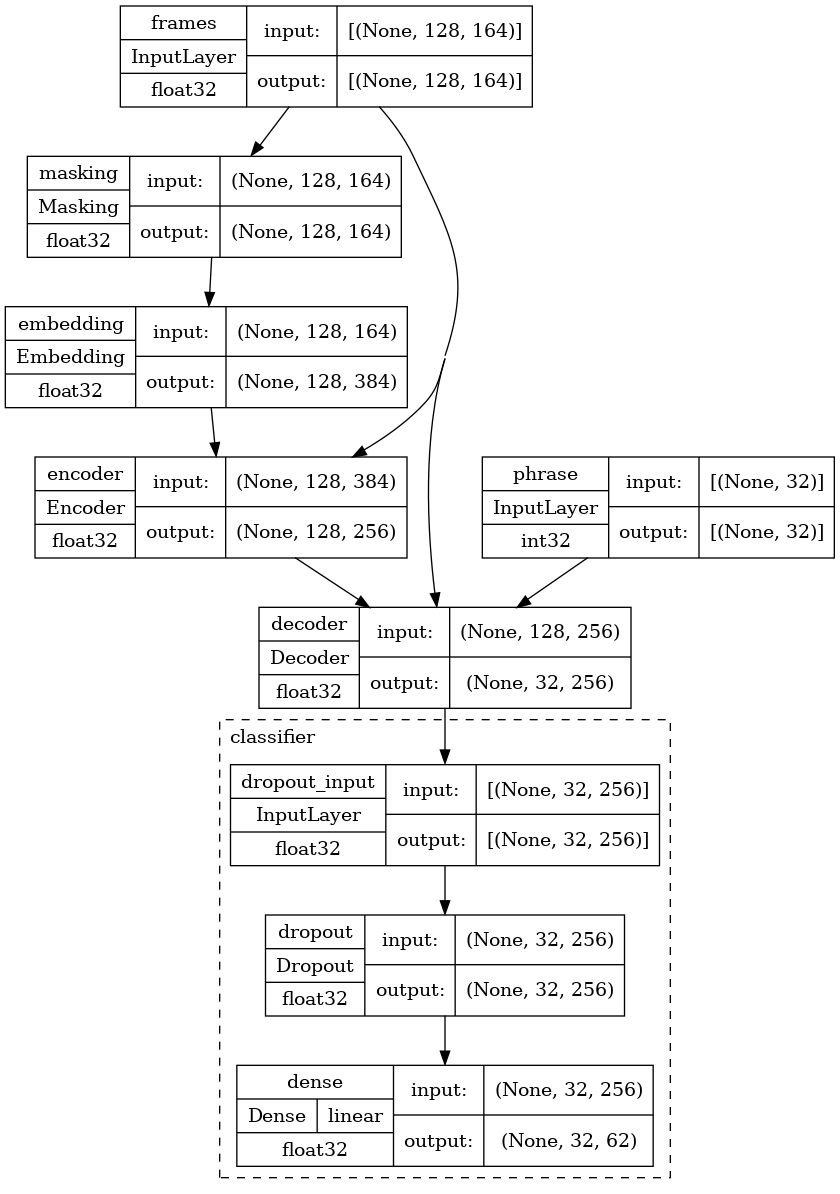

In [50]:
# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Verify Training Flag

Comprobamos ahora si funciona correctamente:

En el primer assert se obtienen las predicciones del modelo utilizando el conjunto de datos de entrada `X_batch_small` con el indicador `training=False`. Esto significa que se está realizando una inferencia estática, donde el modelo no se actualizará ni cambiará durante este proceso. Las predicciones se almacenan en la variable `pred`.

Luego, se realiza un bucle `for` diez veces para verificar si las predicciones son consistentes en múltiples ejecuciones de inferencia. Se hace esto comparando las predicciones originales con nuevas predicciones obtenidas utilizando nuevamente el conjunto de datos de entrada `X_batch_small` y el indicador de entrenamiento en `training=False`. Para esta comparación, se utiliza la función `tf.cast` para asegurarse de que las predicciones sean de tipo int8 (enteros de 8 bits) y luego se reduce el tensor resultante utilizando `tf.reduce_min`.

La función `tf.reduce_min` se utiliza para encontrar el valor mínimo en el tensor resultante, que debe ser igual a 1. Esto significa que todas las predicciones originales y las nuevas predicciones deben ser idénticas, lo que indica que el modelo produce resultados estáticos coherentes durante la inferencia.

En el segundo assert, nuevamente se obtienen las predicciones utilizando el conjunto de datos de entrada `X_batch_small`, pero esta vez con el indicador `training=True`. Esto simula el proceso de entrenamiento, donde el modelo utiliza la técnica de dropout para reducir el sobreajuste y mejorar la generalización. El dropout consiste en desactivar aleatoriamente algunas neuronas durante el entrenamiento para evitar que el modelo se vuelva demasiado dependiente de ciertas características específicas de los datos de entrenamiento.

Luego, se realiza un bucle `for` diez veces para verificar si las predicciones varían significativamente en múltiples ejecuciones durante el entrenamiento. Para ello, se compara el tensor de predicciones originales (calculado en el paso 1) con nuevas predicciones obtenidas con el conjunto de datos `X_batch_small` y el indicador de entrenamiento en `True`. Se utiliza la función `tf.cast` para asegurarse de que las predicciones sean de tipo float32 (números de punto flotante) y luego se calcula la media utilizando `tf.reduce_mean`.

Se espera que el valor medio resultante sea mayor que 0.99, lo que significa que al menos el 99% de las predicciones en cada ejecución durante el entrenamiento son diferentes entre sí debido al dropout aplicado. Esto es una indicación de que el modelo está utilizando diferentes subconjuntos de neuronas en diferentes ejecuciones, lo que es deseable para mejorar la generalización y reducir el sobreajuste.

In [51]:
print(X_batch_small['frames'].shape)
print(X_batch_small['phrase'].shape)

(32, 128, 164)
(32, 32)


In [52]:
def verify_correct_training_flag():
    # Verify static output for inference
    pred = model(X_batch_small, training=False)
    for _ in tqdm(range(10)):
        assert tf.reduce_min(tf.cast(pred == model(X_batch_small, training=False), tf.int8)) == 1

    # Verify at least 99% varying output due to dropout during training
    for _ in tqdm(range(10)):
        assert tf.reduce_mean(tf.cast(pred != model(X_batch_small, training=True), tf.float32)) > 0.99
        
verify_correct_training_flag()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Verify No NaN Predictions

Comprobamos ahora si hay valores NaN en las predicciones realizadas por el modelo.

El código comienza utilizando el método "predict" del modelo para obtener las predicciones del conjunto de datos de entrenamiento ("train_dataset"), ya que no se está utilizando el conjunto de validación. Se especifica la cantidad de pasos a realizar utilizando el parámetro `steps`, que se establece en `N_VAL_STEPS_PER_EPOCH` si se utiliza el conjunto de validación o en 100 si no se utiliza el conjunto de validación (usamos por tanto 100). El parámetro "verbose" se establece en 1.

Una vez que se obtienen las predicciones, el código cuenta cuántos valores NaN hay en el resultado utilizando la función `np.isnan(y_pred).sum()`. Si el resultado de esta cuenta es mayor que cero, significa que hay valores NaN en las predicciones.

Luego, el código muestra un histograma de las predicciones para visualizar la distribución de los logits. En este contexto, los logits son los valores de salida de una red neuronal antes de aplicar una función de activación, como la función softmax. Los logits representan las puntuaciones o puntajes asociados a cada clase en un problema de clasificación.

Por ejemplo, supongamos que tienes un problema de clasificación con tres clases: "perro", "gato" y "pájaro". Después de entrenar una red neuronal, esta producirá un conjunto de valores numéricos como resultado para una entrada dada, que corresponderán a los logits para cada clase. Por ejemplo, podrías obtener [2.5, 1.8, 0.1] como logits para una imagen dada. Estos valores representan las puntuaciones o niveles de confianza que la red asigna a cada clase. En este caso, la red está más segura de que la imagen es un "perro" porque el valor más alto es 2.5, seguido de "gato" con 1.8 y "pájaro" con 0.1.

Después de obtener los logits, generalmente aplicamos una función de activación, como la función softmax, para convertir estos valores en probabilidades, de modo que sumen 1 y podamos interpretarlos como las probabilidades de que la entrada pertenezca a cada clase. En este ejemplo, después de aplicar la función softmax, podríamos obtener [0.64, 0.29, 0.07], lo que indica que la red tiene una probabilidad del 64% de que la imagen sea un "perro", del 29% de que sea un "gato" y del 7% de que sea un "pájaro".

Esto es útil para comprender cómo se distribuyen las predicciones y si hay valores extremadamente altos o bajos que podrían indicar un problema.

100/100 - 7s - 7s/epoch - 67ms/step
# NaN Values In Predictions: 0


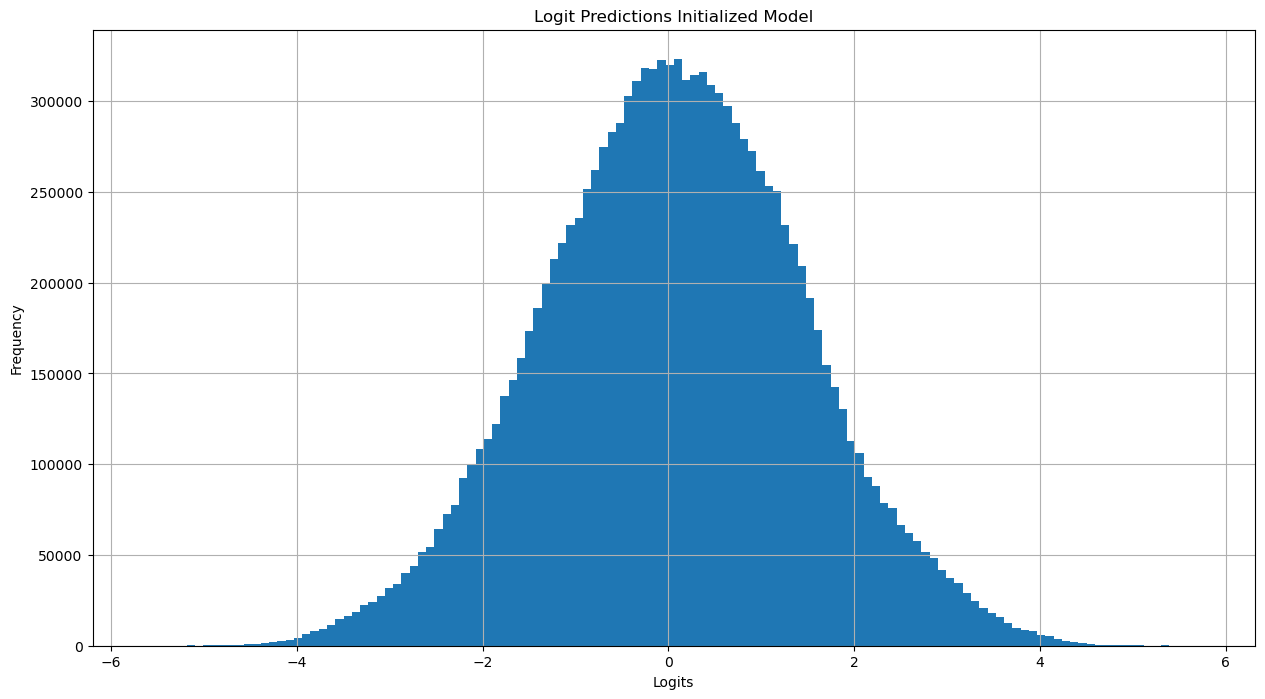

In [53]:
# Verify No NaN predictions
def verify_no_nan_predictions():
    y_pred = model.predict(
        val_dataset if USE_VAL else train_dataset,
        steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else 100,
        verbose=VERBOSE,
    )

    print(f'# NaN Values In Predictions: {np.isnan(y_pred).sum()}')
    
    plt.figure(figsize=(15,8))
    plt.title(f'Logit Predictions Initialized Model')
    pd.Series(y_pred.flatten()).plot(kind='hist', bins=128)
    plt.xlabel('Logits')
    plt.grid()
    plt.show()
    
verify_no_nan_predictions()

# Learning Rate Scheduler

Ahora, definimos la función llamada `lrfn`, que utilizaremos para calcular el learning rate durante el entrenamiento del modelo.

La función `lrfn` toma varios argumentos:

- `current_step`: El paso de entrenamiento actual, que indica cuántos pasos se han completado hasta ahora en el entrenamiento del modelo.
- `num_warmup_steps`: El número de pasos de entrenamiento que se utilizan para el calentamiento (`warm-up`) del `learning rate`. Durante el calentamiento, el `learning rate` aumenta gradualmente desde un valor muy pequeño hasta su valor máximo.
- `lr_max`: El valor máximo que puede tomar el `learning rate` durante el entrenamiento. Después del calentamiento, el `learning rate` oscilará entre 0 y este valor máximo.
- `num_cycles`: El número de ciclos completos de oscilación del `learning rate`. Un ciclo completo significa que el `learning rate` va desde su valor máximo hasta 0 y luego regresa a su valor máximo. Un valor de 0.50 indica que habrá medio ciclo completo.
- `num_training_steps`: El número total de pasos de entrenamiento que se llevarán a cabo durante todo el entrenamiento del modelo.

El objetivo principal de la función `lrfn` es calcular el `learning rate` para cada paso de entrenamiento. Ello se divide en dos partes:

1. Calentamiento del `Learning Rate`: Si el paso de entrenamiento actual es menor que el número de pasos de calentamiento (`num_warmup_steps`), entonces el `learning rate` aumentará gradualmente desde un valor muy pequeño hacia su valor máximo. Se utilizan dos métodos posibles de calentamiento: logarítmico (`'log'`) o exponencial (`2 ** -`). Esto permite que el modelo se adapte de manera más suave a los datos al comienzo del entrenamiento.
2. Oscilación del `Learning Rate`: Después de los pasos de calentamiento, el `learning rate` oscilará entre 0 y su valor máximo (`lr_max`). La forma de esta oscilación sigue una función coseno modificada, que va desde 0 a 1 y luego vuelve a 0 a medida que avanzan los ciclos.

In [54]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

Ahora, se define una función `plot_lr_schedule` que se utilizará para visualizarla tasa de aprendizaje. La función recibe dos argumentos:
- `lr_schedule`: Una lista que contiene los valores de la tasa de aprendizaje para cada paso de entrenamiento (`epoch`).
- `epochs`: El número total de `epochs` de entrenamiento.

- Se traza una línea para el learning rate programado (`lr_schedule`). Se agrega un valor None al inicio y al final para evitar que la línea llegue hasta los bordes del gráfico.
- Se trazan puntos en el gráfico para cada learning rate en lr_schedule. Dependiendo del número total de `epochs`, se muestran solo algunos puntos para evitar que el gráfico se vuelva demasiado denso. Los puntos se etiquetan con los valores del learning rate.

Luego, se crea una lista llamada `LR_SCHEDULE` utilizando la función `lrfn` que calcula el learning rate para cada step en el número de épocas, que en este caso es 20, y dibujamos el gafico viendo el learning rate de cada época. 

Finalmente, se crea un callback de Keras llamado `lr_callback`, que se utilizará durante el entrenamiento del modelo. Este callback ajustará automáticamente la tasa de aprendizaje en cada `epoch` de entrenamiento utilizando la función lambda `step: LR_SCHEDULE[step]`. El valor de la tasa de aprendizaje para cada `epoch` se obtendrá de la lista `LR_SCHEDULE` que se creó anteriormente.

In [55]:
print(f'N_EPOCHS: {N_EPOCHS}')
print(f'N_WARMUP_EPOCHS: {N_WARMUP_EPOCHS}')

N_EPOCHS: 100
N_WARMUP_EPOCHS: 10


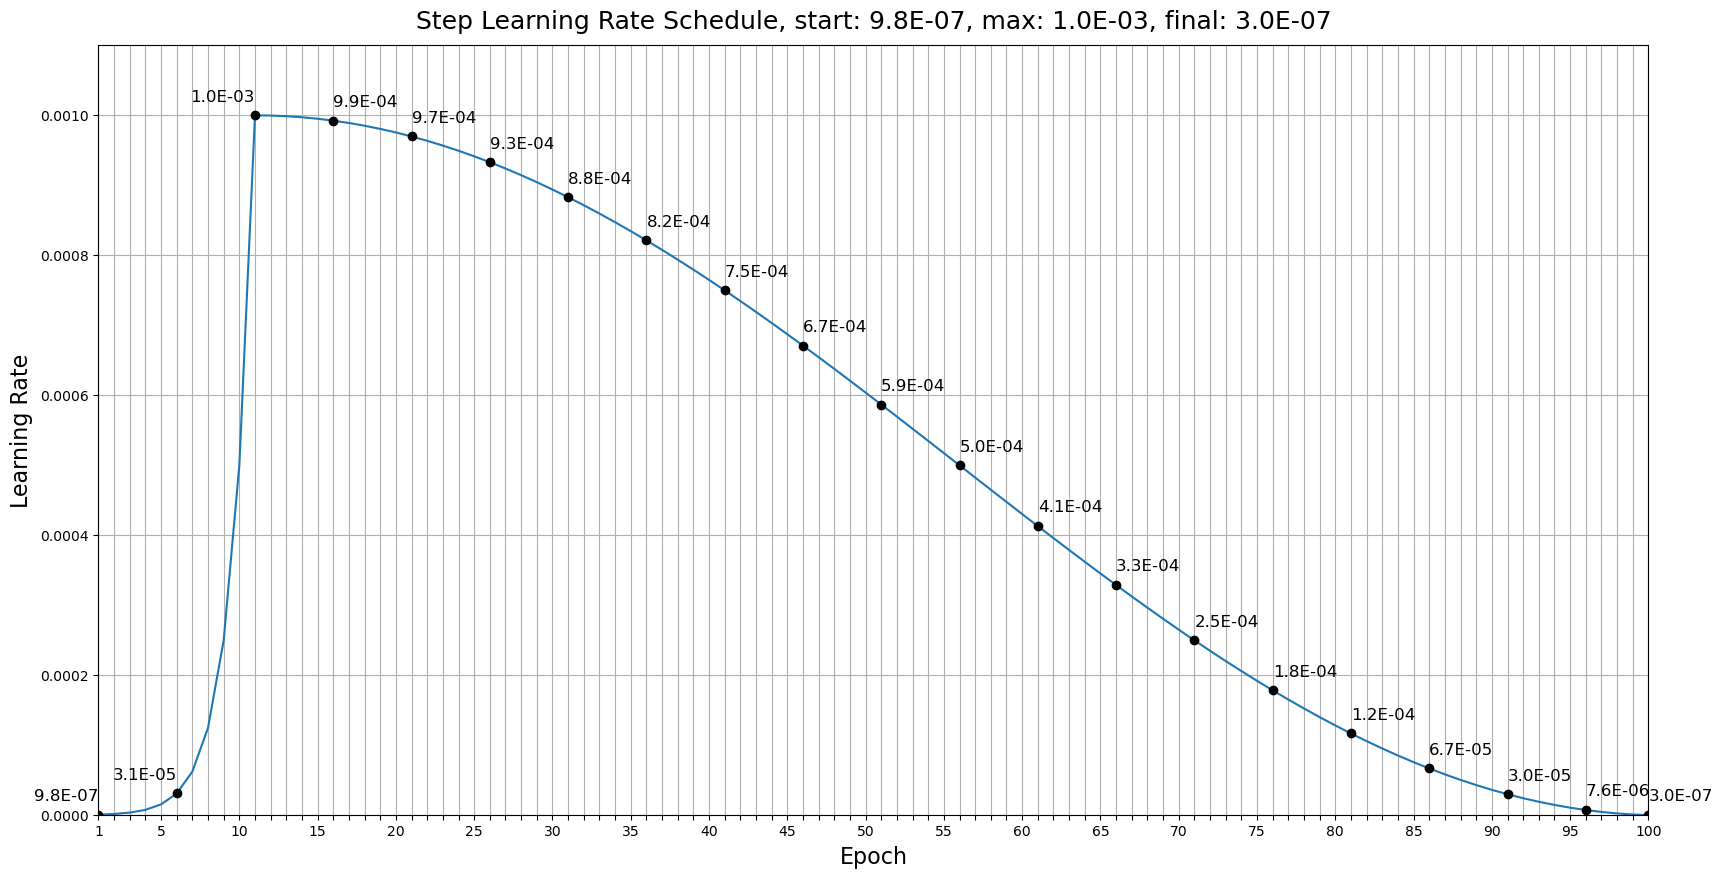

In [56]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Weight Decay Callback


Este fragmento de código define una clase de callback personalizado llamado WeightDecayCallback, que se utilizará durante el entrenamiento del modelo para actualizar el término de "weight decay" (decaimiento de peso) en el optimizador en función de la tasa de aprendizaje.

El weight decay, también conocido como "L2 regularization", es una técnica utilizada en el entrenamiento de modelos de aprendizaje automático para prevenir el sobreajuste (overfitting) y mejorar la generalización del modelo.

En términos simples, el weight decay consiste en agregar un término de penalización a la función de pérdida del modelo que está relacionado con los valores de los pesos del modelo. Este término de penalización es proporcional al cuadrado de los valores de los pesos y se agrega a la función de pérdida durante el proceso de optimización.

El objetivo del weight decay es penalizar los pesos grandes del modelo, lo que significa que el modelo tiene menos probabilidad de ajustar sus pesos a valores extremadamente grandes que podrían causar sobreajuste. Al penalizar los pesos grandes, el modelo se ve incentivado a utilizar pesos más pequeños, lo que puede mejorar la generalización y evitar que el modelo memorice los datos de entrenamiento en lugar de aprender patrones generales.

El callback WeightDecayCallback tiene un constructor __init__ que toma un parámetro opcional wd_ratio, que representa la proporción de weight decay respecto a la tasa de aprendizaje (por defecto es igual a WD_RATIO).

El callback tiene un método on_epoch_begin, que se ejecuta al comienzo de cada época durante el entrenamiento del modelo. En este método, se actualiza el weight decay en el optimizador multiplicando la tasa de aprendizaje actual del modelo por el valor del wd_ratio. Esto permite que el weight decay se ajuste automáticamente en función del learning rate, lo que puede ayudar a mejorar la regularización del modelo y prevenir el sobreajuste.

Además, el método on_epoch_begin imprime en pantalla el valor actual de la tasa de aprendizaje y el weight decay, lo que proporciona información útil durante el entrenamiento para monitorear cómo estos valores están cambiando a lo largo de las épocas.

In [57]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Evaluate Initialized Model

Evaluamos ahora el modelo con el set de datos de entrenamiento

In [58]:
# Evaluate Initialized Model On Validation Data
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    verbose=VERBOSE,
)

969/969 - 49s - loss: 4.9259 - top1acc: 0.0194 - top5acc: 0.0863 - 49s/epoch - 51ms/step


[4.925861835479736, 0.01935415342450142, 0.08627739548683167]

# Baseline

Este fragmento de código calcula la "baseline accuracy" o precisión de referencia para el modelo cuando solo se predice el token de relleno (`PAD_TOKEN`).

En este caso particular, la "precisión de referencia" se refiere a la precisión del modelo cuando solo se predice el token de relleno (`PAD_TOKEN`) para todas las muestras en el conjunto de datos. Esta precisión se calcula como la proporción de muestras en el conjunto de datos que contienen solo el token de relleno.

Es importante calcular la "precisión de referencia" para tener una idea de cómo se comportaría un modelo simple o ingenuo que siempre predice el valor más común (el token de relleno). Si el modelo que estamos construyendo no supera significativamente esta precisión de referencia, indica que el modelo no está aprendiendo patrones relevantes en los datos y necesita mejorar para ser útil en la tarea que se está abordando.

Si la variable `USE_VAL` es verdadera, significa que se está utilizando el conjunto de validación para calcular la precisión de referencia. En caso contrario, se utiliza el conjunto de entrenamiento.

La precisión de referencia se calcula comparando las etiquetas reales (`y_val` o `y_train`) con el valor del token de relleno (`PAD_TOKEN`). El token de relleno se utiliza en secuencias para indicar posiciones vacías o sin información relevante.

El cálculo de la precisión de referencia se realiza de la siguiente manera:

- Si `USE_VAL=True`, se calcula la precisión de referencia utilizando el conjunto de validación: Se compara cada elemento en el conjunto de validación (`y_val`) con el valor del token de relleno (`PAD_TOKEN`).
- Se obtiene un array booleano que indica si cada elemento es igual al token de relleno o no.
- Se calcula la media de este array booleano para obtener la proporción de elementos que son iguales al token de relleno. Esta proporción representa la precisión de referencia en el conjunto de validación.
- Si `USE_VAL=False`, se realiza el mismo proceso pero utilizando el conjunto de entrenamiento (y_train) en su lugar.

Una precisión de referencia alta podría indicar que el modelo necesita mejorar para ser útil en la tarea que se está abordando.

In [59]:
# baseline accuracy when only pad token is predicted
if USE_VAL:
    baseline_accuracy = np.mean(y_val == PAD_TOKEN)
else:
    baseline_accuracy = np.mean(y_train == PAD_TOKEN)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.4100


# Train

llamamos manualmente a gc.collect() para liberar la memoria no utilizada:

In [60]:
gc.collect()

28047

Procedemos ahora a entrenar el modelo usando el set de datos `train_dataset`

Los pasos en el entrenamiento del modelo son los siguientes:

1. Primero se limpian todos los modelos anteriores en la GPU para liberar memoria. Esto se hace usando `tf.keras.backend.clear_session()`.

2. Se obtiene un nuevo modelo utilizando la función `get_model()`. Se imprime un resumen del modelo utilizando `model.summary()` para verificar que se ha creado correctamente

4. Se inicia el proceso de entrenamiento del modelo utilizando el método `fit()`. En este método, se proporcionan los siguientes argumentos:
   - `x`: los datos de entrenamiento (`train_dataset`)
   - `steps_per_epoch`: El número de pasos que se realizarán en cada época de entrenamiento. Cada paso es una actualización de los pesos del modelo basada en un lote de muestras.
   - `epochs`: El número total de épocas que se realizarán durante todo el entrenamiento.
   - `validation_data`: los datos de validación (`val_dataset`). En nuestro caso `USE_VAL=False`, por lo que se establece en `None`.
   - `validation_steps`: El número de pasos que se realizarán durante la evaluación en cada época de validación. Tampoco los utilizamos.
   - `callbacks`: Una lista de devoluciones de llamada que se ejecutan durante el entrenamiento. En este caso, se utiliza el callback `lr_callback` para actualizar el learning rate y el callback `WeightDecayCallback()` para actualizar el peso de decaimiento (weight decay) durante el entrenamiento.
   - `verbose`: Un valor entero que controla la cantidad de información que se muestra durante el entrenamiento. Un valor de 0 muestra nada, un valor de 1 muestra una barra de progreso, y un valor de 2 muestra una barra de progreso y el resumen de cada época.

In [61]:
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')
print(f'N_EPOCHS: {N_EPOCHS}')
print(f'VERBOSE: {VERBOSE}')

TRAIN_STEPS_PER_EPOCH: 969
N_EPOCHS: 100
VERBOSE: 2


In [62]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()
    print('\n\n')
    # Actual Training
    history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            validation_data=val_dataset if USE_VAL else None,
            validation_steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else None,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              (None, 128, 256)     3643392     ['embedding[0][0]',              
                                                                  'frames[0][0]']             

In [63]:
# Load Weights
if LOAD_WEIGHTS: # LOAD_WEIGHTS is set to False
    model.load_weights('/kaggle/input/aslfr-training-python37/model.h5')
    print(f'Successfully Loaded Pretrained Weights')

In [64]:
# Save Model Weights
model.save_weights('model.h5')

Ahora, evaluamos el modelo cargado en el conjunto de datos especificado y calculamos la pérdida y las métricas del modelo en ese conjunto de datos. Es una forma de verificar que el modelo esté cargado correctamente y listo para su uso. Debido a que `train_dataset` es un objeto generador, cada vez que se accede a él se obtiene un nuevo lote de datos diferente. Por ello, no estamos evaluando con los mismos datos con los que entrenamos.

La función `evaluate()` nos imprime 3 valores por pantalla en forma de lista:

- La pérdida (Sparse Categorical Cross Entropy with Label Smoothing en nuestro caso): medida de qué tan bien se ajustan las predicciones del modelo a las etiquetas verdaderas durante el entrenamiento. Una pérdida más baja indica un mejor ajuste del modelo a los datos de entrenamiento.
- Precisión Top-1 (TopKAccuracy(1)): Esta es la precisión top-1, también conocida como precisión en el ranking de mayor probabilidad. Representa la fracción de muestras en las que el modelo predice correctamente la clase verdadera como la clase con la mayor probabilidad. Es decir, es la precisión para el caso en que se toma solo la clase más probable como predicción.
- Precisión Top-5 (TopKAccuracy(5)): Esta es la precisión top-5, que representa la fracción de muestras en las que el modelo predice correctamente la clase verdadera como una de las cinco clases con las mayores probabilidades. En otras palabras, se consideran las cinco clases más probables y se verifica si la clase verdadera está presente en esas cinco clases.

In [65]:
# Verify Model is Loaded Correctly
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

969/969 - 48s - loss: 1.7494 - top1acc: 0.9081 - top5acc: 0.9742 - 48s/epoch - 50ms/step


[1.7493573427200317, 0.9081131219863892, 0.9741507768630981]

# Levenshtein Distance

Definimos una función llamada `outputs2phrase`, que se utiliza para convertir las salidas (`outputs`) del modelo en una secuencia de texto (frase). La función toma como entrada las salidas del modelo, que pueden ser un tensor de dos dimensiones o un tensor unidimensional. La función realiza lo siguiente:

1. Si las salidas tienen dos dimensiones, se toma el índice de la clase con la probabilidad más alta para cada muestra utilizando `np.argmax(outputs, axis=1)`. Esto se hace asumiendo que las salidas son probabilidades de clases, y el modelo ha predicho la clase con la mayor probabilidad para cada muestra.

2. Luego, la función recorre los índices de las clases predichas y utiliza un diccionario llamado `ORD2CHAR` para convertir los índices en caracteres. `ORD2CHAR` es un diccionario que mapea los índices de las clases a los caracteres correspondientes en la secuencia de texto. Por ejemplo, el índice 0 podría estar mapeado al carácter "a", el índice 1 al carácter "b" y así sucesivamente.

3. Finalmente, la función une todos los caracteres para formar la secuencia de texto completa y la devuelve como resultado.

En resumen, esta función es útil para convertir las salidas del modelo, que son índices de clases o probabilidades, en una secuencia de texto legible para interpretar las predicciones del modelo en forma de texto.

In [66]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

Ahora, definimos la función llamada `predict_phrase` que se utiliza para generar predicciones de texto basadas en una secuencia de frames de entrada utilizando un modelo de lenguaje entrenado previamente.

Aquí están los pasos detallados de la función `predict_phrase`:

1. La función está decorada con `@tf.function()` para convertirla en un grafo de TensorFlow y obtener beneficios de rendimiento al ejecutarla.

2. La función toma el tensor `frames` como entrada, secuencia de frames igual que hemos visto anteriormente (`X_batch['frames']`).

3. Se agrega una dimensión batch dimension al tensor `frames` utilizando `tf.expand_dims()`. Esto es necesario porque el modelo espera una entrada con una dimensión de lote, incluso si estamos haciendo una predicción para un solo ejemplo.

4. Se inicializa la variable `phrase` con la forma `[1, MAX_PHRASE_LENGTH]` y se llena con el token de relleno (`PAD_TOKEN`). Esta variable se utiliza para almacenar la secuencia de texto generada.

5. Se inicia un bucle que se ejecutará `MAX_PHRASE_LENGTH` veces, que es el máximo número de tokens en la secuencia de texto generada.

6. Dentro del bucle, se realiza lo siguiente:

   * Se convierte `phrase` a tipo `int8`.
   * Se llama al modelo con las entradas `X = frames` e `y = phrase` utilizando el método `model()` para obtener las predicciones del modelo para el siguiente token en la secuencia de texto. Estas predicciones se almacenan en la variable `outputs`.
   *  `phrase = tf.cast(phrase, tf.int32)`: Se convierte el tensor `phrase` al tipo de datos int32. Esto es necesario para asegurarnos de que podamos utilizar la función `tf.where()` correctamente, ya que requiere que los argumentos tengan el mismo tipo de datos.
   * `tf.range(MAX_PHRASE_LENGTH) < idx + 1`: Se crea un tensor booleano con forma `[MAX_PHRASE_LENGTH]=32`, donde cada elemento es `True` si su índice es menor que `idx + 1`, y `False` en caso contrario. Esto crea una máscara que indica qué posiciones de la secuencia de texto aún no han sido predichas.
   * `tf.argmax(outputs, axis=2, output_type=tf.int32)`: Se utiliza la función `tf.argmax()` para encontrar el índice del token con la mayor probabilidad en las predicciones (`outputs`). El argumento `axis=2` indica que la búsqueda del máximo se realizará a lo largo del tercer eje de `outputs`, que corresponde a las diferentes clases o tokens posibles en la secuencia de texto. El argumento `output_type=tf.int32` asegura que el resultado de `tf.argmax()` será de tipo entero `int32`.
   * `tf.where(condition, x, y)`: Esta función realiza una operación de "selección condicional". Toma tres argumentos: `condition`, `x` e `y`. Si `condition` es `True` en una posición, el valor de `x` en esa posición se selecciona; de lo contrario, se selecciona el valor de `y`. En este caso, `condition` es la máscara creada en el paso 2, `x` es el resultado de `tf.argmax()` en el paso 3 (es decir, el índice del token predicho), e `y` es la secuencia de texto actual (`phrase`). Esto significa que si una posición en la máscara es `True`, se selecciona el token predicho en esa posición; de lo contrario, se mantiene el token actual en esa posición.

   * Al final de esta operación, la variable `phrase` se ha actualizado con el token predicho en la posición correspondiente, lo que permite que el bucle itere y agregue el siguiente token en la siguiente posición de la secuencia de texto. De esta manera, la secuencia de texto se va construyendo paso a paso hasta completarla con `MAX_PHRASE_LENGTH` tokens, y así se obtiene la secuencia de texto generada por el modelo de lenguaje.

7. Una vez finalizado el bucle, el tensor `phrase` se comprime para eliminar la dimensión de lote agregada anteriormente, ya que solo estamos generando una secuencia de texto para un solo ejemplo.

8. Los valores numéricos en `phrase` se convierten en representación "one-hot" utilizando `tf.one_hot()`. Esta representación "one-hot" es útil para obtener las etiquetas discretas (tokens) en formato numérico.

9. Finalmente, la función devuelve un diccionario con la clave "outputs" y el tensor de salida resultante. Este tensor contiene la secuencia de texto generada en formato "one-hot" con forma `[MAX_PHRASE_LENGTH, N_UNIQUE_CHARACTERS]`.

En resumen, la función `predict_phrase` toma una secuencia de frames de entrada y utiliza el modelo de lenguaje para predecir la siguiente palabra en la secuencia de texto generada. Luego, itera para predecir todas las palabras de la secuencia. La función devuelve la secuencia de texto generada en formato "one-hot" para representar los tokens numéricamente.

In [67]:
print(tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)) # MAX_PHRASE_LENGTH = 32
print(tf.cast(tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN), tf.int8))

tf.Tensor(
[[59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
  59 59 59 59 59 59 59 59]], shape=(1, 32), dtype=int32)
tf.Tensor(
[[59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
  59 59 59 59 59 59 59 59]], shape=(1, 32), dtype=int8)


In [68]:
@tf.function()
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)

    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where( # where its True search for max prob, if its False keep Pad token
            tf.range(MAX_PHRASE_LENGTH) < idx + 1, # create a mask of Trues and Falses
            tf.argmax(outputs, axis=2, output_type=tf.int32), # search for the max probability
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0) # drop first dimension
    outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS) # one-hot encoding of the numbers

    # Return a dictionary with the output tensor
    return outputs

# Levenstein Distance Train

Con estas dos funciones, creamos una última función, llamada `get_ld_train`, que se utiliza para calcular la distancia entre las frases real y la frase predicha por el modelo en el conjunto de entrenamiento.

La función toma como entrada los datos de entrenamiento `X_train` y las etiquetas reales `y_train`, que contienen secuencias de 'frames' y 'phrases' representadas por índices enteros, respectivamente.

Creamos una lista vacía llamada `LD_TRAIN` que se utilizará para guardar las distancias de Levenshtein de cada par de frases reales y predichas.

Luego, la función itera a través de los datos de entrenamiento utilizando un bucle `for`. Para cada par de 'frames' y 'phrase', realiza lo siguiente:

1. Utiliza la función `predict_phrase` para predecir la frase a partir de los frames de entrada. La función `predict_phrase` toma los frames como entrada y devuelve la secuencia predicha de caracteres en formato "one-hot". Posteriormente, utiliza la función `outputs2phrase` para convertir la secuencia predicha de caracteres a una cadena legible.

2. Convierte la frase real de índices enteros a una cadena legible utilizando la función `outputs2phrase`.

3. Calcula la distancia de Levenshtein entre la frase real y la frase predicha utilizando la función `levenshtein`. La distancia de Levenshtein es una medida de la diferencia entre dos cadenas, que se calcula contando el número mínimo de operaciones (inserciones, eliminaciones o sustituciones de caracteres) requeridas para transformar una cadena en la otra.

4. Mete la frase real, la frase predicha y la distancia de Levenshtein en la lista `LD_TRAIN`.

Después de completar el bucle, la función convierte la lista `LD_TRAIN` en un DataFrame de pandas llamado `LD_TRAIN_DF` y lo devuelve como resultado.

In [69]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')

Shape X_train: (61955, 128, 164)
Shape y_train: (61955, 32)


`zip(tqdm(X_train, total=N)` en cada iteración del bucle, obtiene un par de elementos, uno de X_train y otro de tqdm. Por eso obtenemos 3 elementos en el enumerate, el índice con el tqdm, X_train e y_train

In [70]:
i = 0
N = 100 if IS_INTERACTIVE else 1000
for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
    print(idx)
    print(phrase_true)
    i+=1
    if i == 5:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

0
[18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]
1
[50 34 32 43 36 50 14 42 52 39 32 56 43 32 39 61 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]
2
[39 36 45 51 32 40 39 52 33 50 13 34 46 44 61 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]
3
[16 18 23 18  0 54 40 43 43 40 32 44  0 43 32 45 40 36 49 61 59 59 59 59
 59 59 59 59 59 59 59 59]
4
[24 23 23  0 37 49 32 45 42 43 40 45  0 43 32 45 36 61 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]


In [71]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)
    
    return LD_TRAIN_DF

In [72]:
LD_TRAIN_DF = get_ld_train()

# add column to see the length of the true phrase
LD_TRAIN_DF['len_char'] = LD_TRAIN_DF['phrase_true'].apply(lambda x: len(x))

# Display Errors
display(LD_TRAIN_DF.head(30))

  0%|          | 0/1000 [00:00<?, ?it/s]

,phrase_true,phrase_pred,levenshtein_distance,len_char
0,3 creekhouse,3 creekhouse,0,12
1,scales/kuhaylah,scales/kuhaylaaa,2,15
2,hentaihubs.com,hentaihubs.com,0,14
3,1383 william lanier,1383 william lanier,0,19
4,988 franklin lane,988 franklin lanee,1,17
5,6920 northeast 661st road,6920 northeast 661st road,0,25
6,www.freem.ne.jp,www.freem.me.jp.jp,4,15
7,https://jsi.is/hukuoka,https://jsi.is/hkuokaa,2,22
8,239613 stolze street,239613 stolze street street,7,20
9,242-197-6202,211-766-0212,7,12


Ahora, calculamos la distribución de las distancias de Levenshtein en el conjunto de entrenamiento y creamos un gráfico de barras para visualizar cómo se distribuyen estas distancias en el conjunto de datos.

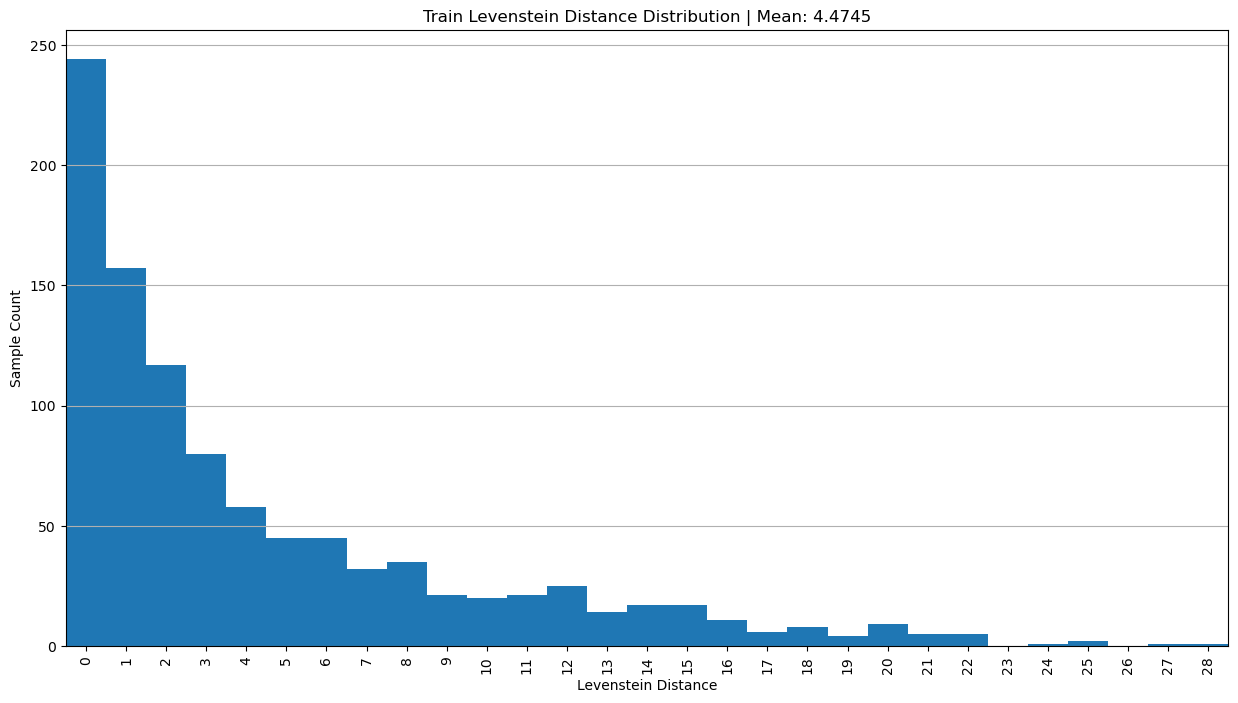

In [73]:
# Value Counts
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

plt.figure(figsize=(15,8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.levenshtein_distance.mean():.4f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.levenshtein_distance.max()+0.50)
plt.grid(axis='y')
plt.savefig('temp.png')
plt.show()

# Levenstein Distance Evaluation

Hacemos lo mismo para el conjunto de validación:

In [74]:
# Compute Levenstein Distances
def get_ld_val():
    N = 100 if IS_INTERACTIVE else 1000
    LD_VAL = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val, total=N), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_VAL.append({
            'phrase_true': phrase_true,
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_VAL_DF = pd.DataFrame(LD_VAL)
    
    return LD_VAL_DF

In [75]:
if USE_VAL:
    LD_VAL_DF = get_ld_val()

    # Display Errors
    display(LD_VAL_DF.head(30))

In [76]:
# Value Counts
if USE_VAL:
    LD_VAL_VC = dict([(i, 0) for i in range(LD_VAL_DF['levenshtein_distance'].max()+1)])
    for ld in LD_VAL_DF['levenshtein_distance']:
        LD_VAL_VC[ld] += 1

    plt.figure(figsize=(15,8))
    pd.Series(LD_VAL_VC).plot(kind='bar', width=1)
    plt.title(f'Validation Levenstein Distance Distribution | Mean: {LD_VAL_DF.levenshtein_distance.mean():.4f}')
    plt.xlabel('Levenstein Distance')
    plt.ylabel('Sample Count')
    plt.xlim(0-0.50, LD_VAL_DF.levenshtein_distance.max()+0.50)
    plt.grid(axis='y')
    plt.savefig('temp.png')
    plt.show()

# Training History

Una vez entrenado el modelo y creado las predicciones de nuestros datos, se define una función llamada `plot_history_metric` para graficar la evolución de las distintas métricas usadas en el entrenamiento.

Veamos paso a paso qué hace cada parte del código:

- `if not TRAIN_MODEL: return`: Esta línea verifica si la variable `TRAIN_MODEL` es `True` o `False`. Si es `False`, la función no realizará ninguna acción y se detendrá aquí con el `return`. 

- `values = history.history[metric]`: Se obtienen los valores de la métrica especificada (`metric`) del historial del entrenamiento del modelo, que se almacena en el diccionario `history.history`.

- `N_EPOCHS = len(values)`: Se obtiene el número total de épocas de entrenamiento al contar la longitud de los valores de la métrica.

- `val = 'val' in ''.join(history.history.keys())`: Se verifica si la palabra 'val' se encuentra en las palabras clave del historial del modelo (si usamos validación). Si es así, se establece `val=True`, de lo contrario, se establece en `False`.

- `if N_EPOCHS <= 20: x = np.arange(1, N_EPOCHS + 1)`: Si el número de épocas es menor o igual a 20, se crea un arange `x` con valores que van desde 1 hasta el número total de épocas.

- `else: x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]`: Si el número de épocas es mayor a 20, se crea una lista `x` con valores específicos que están espaciados para que el gráfico muestre claramente la evolución de la métrica.

- `x_ticks = np.arange(1, N_EPOCHS+1)`: Se crea otro arange `x_ticks` que contiene los valores desde 1 hasta el número total de épocas. Este se utiliza para definir las etiquetas del eje x en el gráfico.

- Si `val=True`:
    - `val_values = history.history[f'val_{metric}']`: Se obtienen los valores de la métrica de validación específica (`val_{metric}`) del historial del modelo.
    - `val_argmin = f_best(val_values)`: Se encuentra el índice de la métrica de validación que tiene el mejor valor, utilizando la función `f_best` que se especifica como argumento (por defecto es `np.argmax`, lo que encuentra el índice con el valor máximo).
    - `plt.plot(x_ticks, val_values, label=f'val')`: Se traza la evolución de la métrica de validación en el gráfico con la etiqueta 'val'.

- En caso de que `val=False`:
    - `plt.plot(x_ticks, values, label=f'train')`: Se traza la evolución de la métrica de entrenamiento en el gráfico con la etiqueta 'train'.
    - `argmin = f_best(values)`: Se encuentra el índice de la métrica de entrenamiento que tiene el mejor valor, utilizando la función `f_best` que se especifica como argumento (por defecto es `np.argmax`, lo que encuentra el índice con el valor máximo).
    - `plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')`: Se agrega un punto rojo en el gráfico que indica la mejor métrica de entrenamiento y su valor correspondiente.

- Si hay métricas de validación (`val`):
    - `plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')`: Si hay métricas de validación, se agrega un punto morado en el gráfico que indica la mejor métrica de validación y su valor correspondiente.

In [77]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    # Only plot when training
    if not TRAIN_MODEL:
        return
    
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [78]:
history.history.keys() # there's not 'val'

dict_keys(['loss', 'top1acc', 'top5acc', 'lr'])

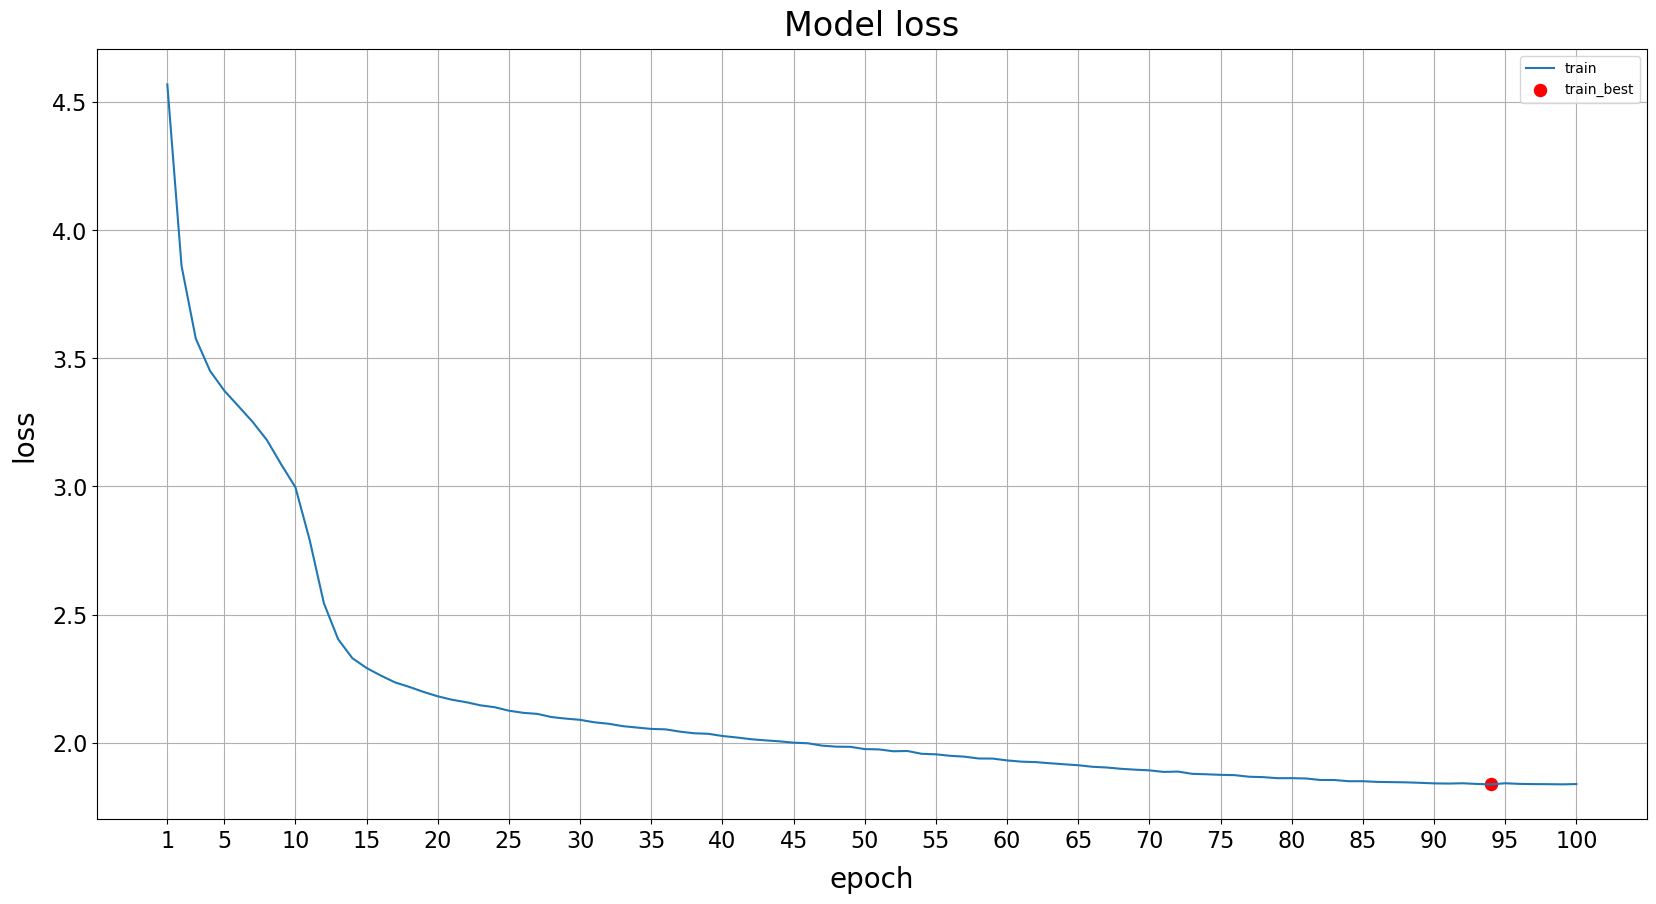

In [79]:
plot_history_metric('loss', f_best=np.argmin)

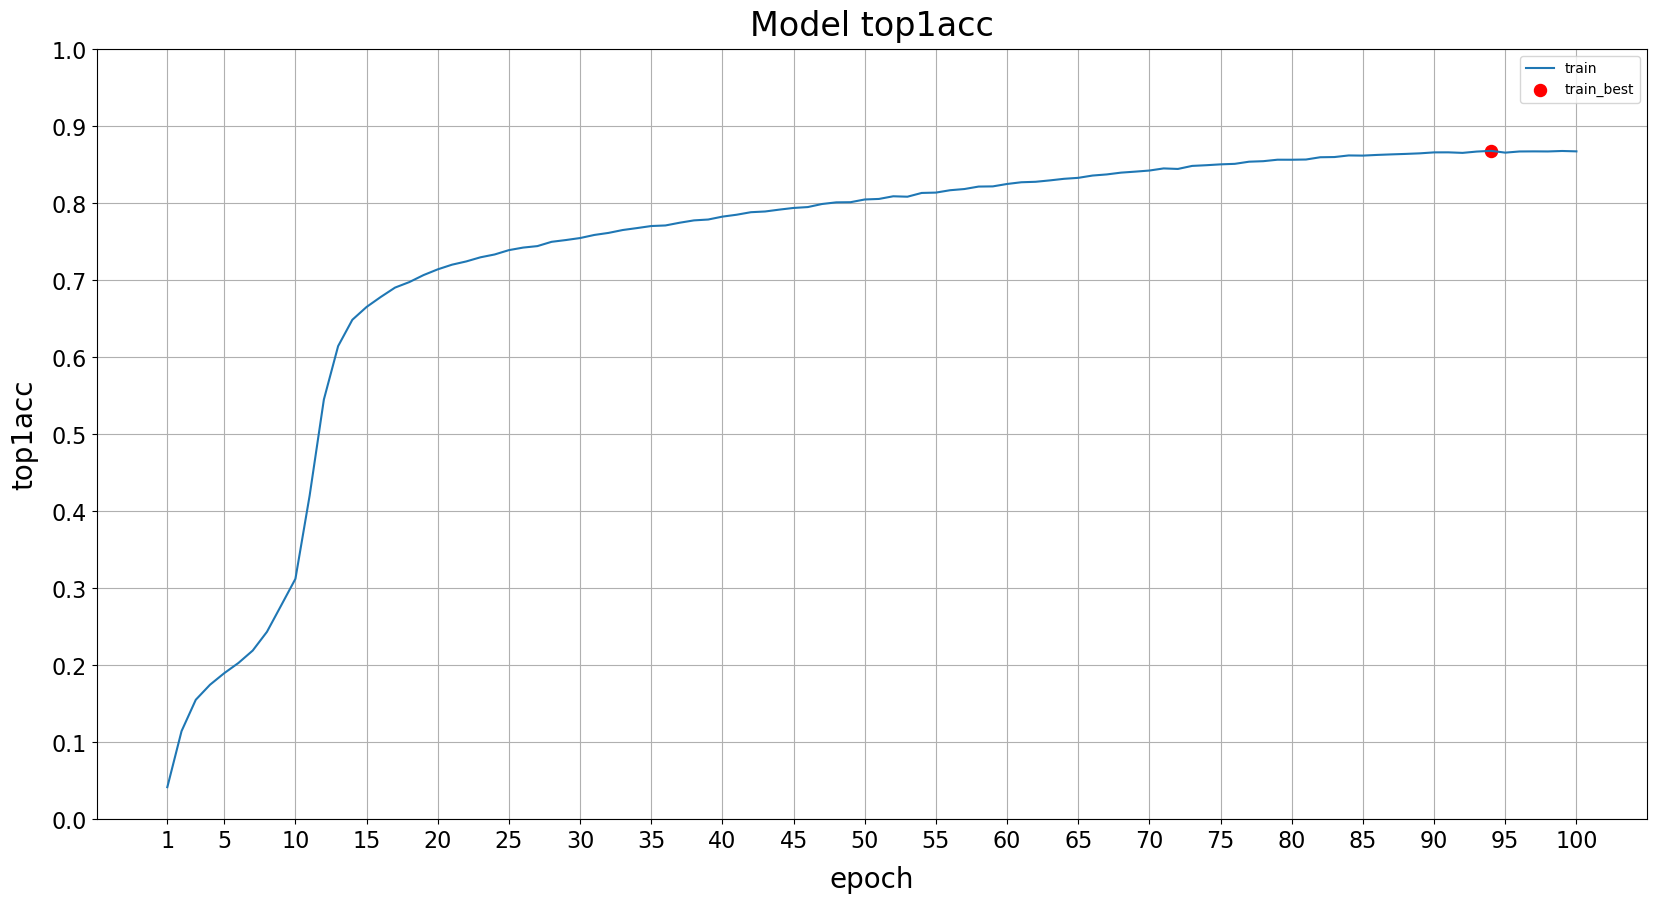

In [80]:
plot_history_metric('top1acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

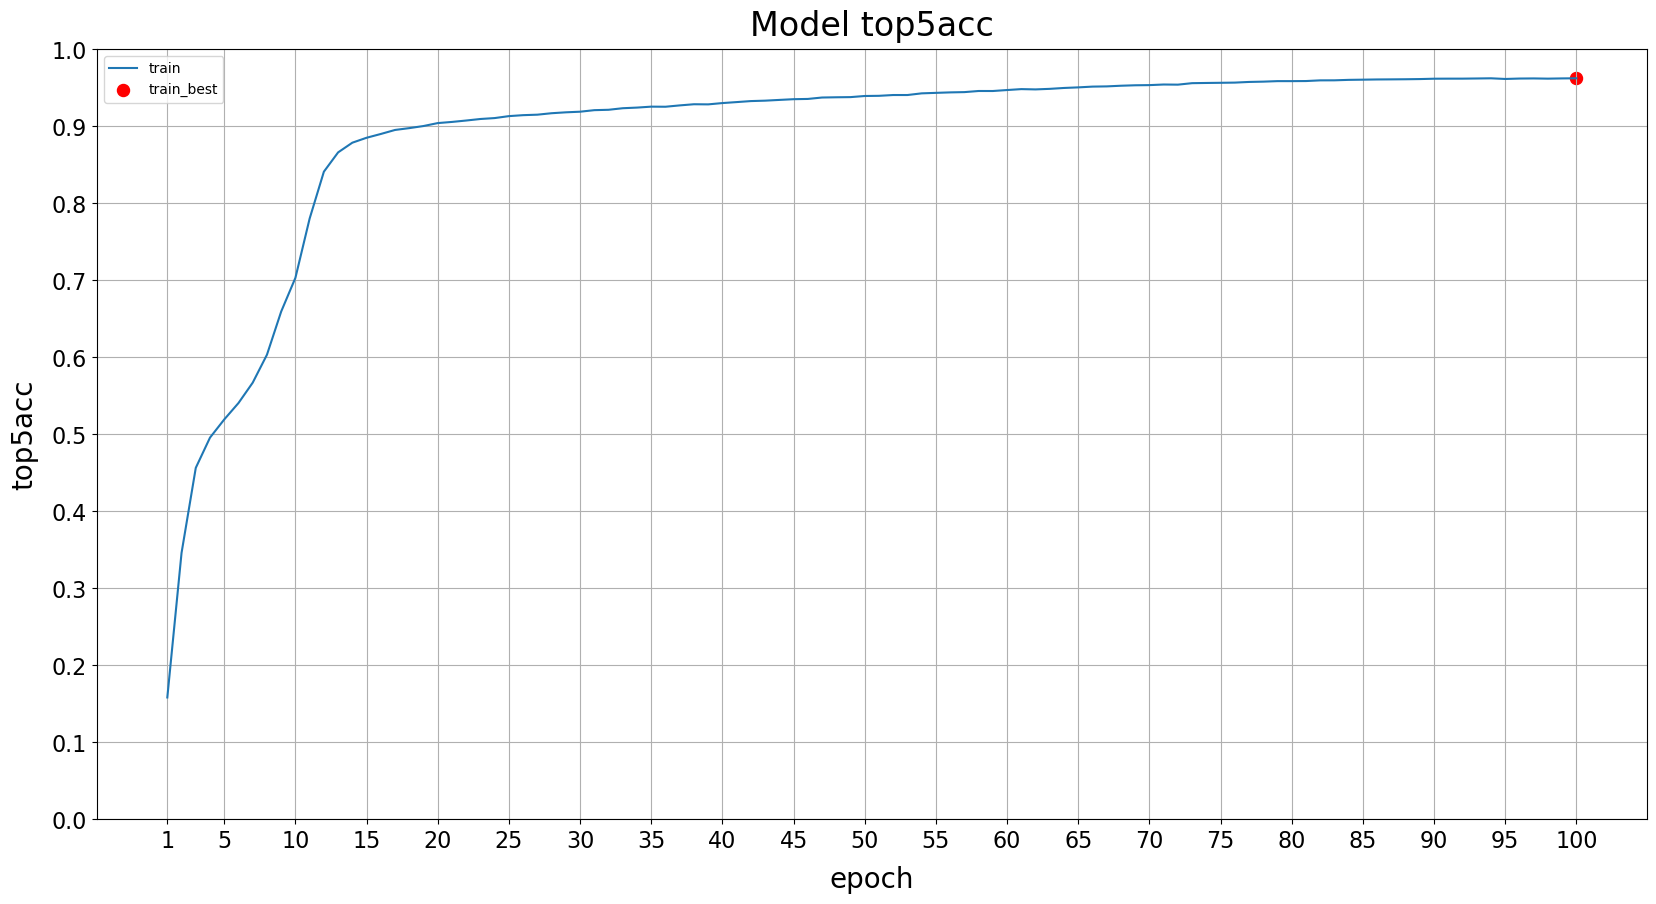

In [81]:
plot_history_metric('top5acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Inference

El siguiente código define la clase `TFLiteModel`, que representa un modelo de TensorFlow Lite (TFLite) construido a partir del modelo previamente entrenado. Esto es es útil cuando se quiere desplegar el modelo en dispositivos con recursos limitados, como teléfonos móviles, dispositivos IoT o sistemas embebidos. TFLite es una versión optimizada de TensorFlow diseñada para inferencias rápidas y eficientes en dispositivos con capacidad computacional limitada.

### Paso a paso:

1. `TFLiteModel(tf.Module)`: Se define una clase llamada `TFLiteModel` que hereda de `tf.Module`, indicando que es una entidad entrenable en TensorFlow.

2. `def __init__(self, model)`: El método `__init__` es el constructor de la clase y se ejecuta automáticamente al crear una instancia de `TFLiteModel`. Recibe el argumento `model`, que es el modelo previamente entrenado que se utilizará como base para el modelo TFLite.

3. `self.preprocess_layer = preprocess_layer`: Se asigna a `self.preprocess_layer` la capa de preprocesamiento que se utiliza para procesar los datos de entrada antes de pasarlos al modelo base.

4. `self.model = model`: Se asigna a `self.model` el modelo previamente entrenado que se utilizará como base para el modelo TFLite.

5. `@tf.function(jit_compile=True)`: Los siguientes métodos están decorados con `@tf.function`, lo que indica que serán compilados por TensorFlow para un rendimiento más rápido.

6. `def encoder(self, x, frames_inp)`: Este método implementa la parte del modelo correspondiente al encoder. De igual forma que al construir el modelo, el encoder toma dos argumentos; `x`, que representa los datos de entrada, y `frames_inp`, que es la forma de los datos. En estaó funcin se hace embedding y luego encoding.

7. `def decoder(self, x, phrase_inp)`: Este método implementa la parte del modelo correspondiente al decoder. De igual forma que al construir el modelo, el decoder toma dos argumentos; `x`, que representa la salida del codificador, y `phrase_inp`, que es la forma de los datos tipo "phrase".

8. `@tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])`: El método `__call__` se define como una función TensorFlow que se utilizará para realizar inferencias con el modelo TFLite. Se especifica la forma y tipo de los datos de entrada utilizando `tf.TensorSpec`.

9. `N_INPUT_FRAMES = tf.shape(inputs)[0]`: Se obtiene el número de filas de la entrada `inputs`, que representa el número de frames.

10. `frames_inp = self.preprocess_layer(inputs)`: Se procesan los datos de entrada utilizando la capa de preprocesamiento `preprocess_layer`.

11. `frames_inp = tf.expand_dims(frames_inp, axis=0)`: Se agrega una dimensión de lote (batch dimension) a `frames_inp` para que coincida con la entrada del modelo original.

12. `encoding = self.encoder(frames_inp, frames_inp)`: Se obtiene la representación codificada de los datos de entrada utilizando el método `encoder` definido anteriormente.

13. `phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)`: De igual forma que hicimos anteriormente, se crea un tensor de forma `[1, MAX_PHRASE_LENGTH]` lleno con el valor `PAD_TOKEN`. Este tensor representa la frase de salida que se irá construyendo durante la inferencia.

14. `for idx in tf.range(MAX_PHRASE_LENGTH)`: Se itera sobre el rango de índices de la longitud máxima de la frase (`MAX_PHRASE_LENGTH=32`).

15. `phrase = tf.cast(phrase, tf.int8)`: Se realiza un casting del tensor `phrase` a tipo `int8`.

16. `outputs = tf.cond(stop, ...)`: Se utiliza una condicional de TensorFlow (`tf.cond`) para determinar si se debe detener la generación de la frase. Si `stop=True` , lo que significa que se predijo el token de final de oración (`END_TOKEN`), se devuelve el tensor `phrase` convertido a one-hot encoding y se detiene la generación de la frase. Si `stop=False`, se continúa generando la siguiente palabra de la frase utilizando el método `decoder`.

17. `phrase = tf.where(tf.range(MAX_PHRASE_LENGTH) < idx + 1, ...)`: Se actualiza el tensor `phrase` reemplazando el token de relleno (`PAD_TOKEN`) con la palabra predicha hasta el índice actual (`idx`) en la generación de la frase.

18. `predicted_token = phrase[0,idx]`: Se obtiene el token predicho en la posición `idx`.

19. `if not stop: stop = predicted_token == END_TOKEN`: Se actualiza la variable `stop` verificando si el token predicho es igual al token de final de oración (`END_TOKEN`). Si es así, se establece `stop` en verdadero, lo que significa que la generación de la frase debe detenerse.

20. `outputs = tf.squeeze(phrase, axis=0)`: Se elimina la dimensión de lote agregada anteriormente para obtener la frase completa generada.

21. `outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)`: Se convierte la frase generada en one-hot encoding.

22. Finalmente, el método `__call__` devuelve un diccionario con la clave `'outputs'` que contiene la frase generada.

Después de definir la clase `TFLiteModel`, se crea una instancia de la misma llamada `tflite_keras_model` y se realiza una demostración de inferencia utilizando datos de entrada `demo_raw_data`. La inferencia se realiza llamando al método `__call__` de `tflite_keras_model` y se muestra la frase generada, la frase verdadera y los datos de entrada en formato de tensor.

In [82]:
# Model Layer Names
for l in model.layers:
    print(l.name)

frames
masking
embedding
encoder
phrase
decoder
classifier


In [83]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == END_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (123, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: 3 creekhouse
phrase true: 3 creekhouse


In [84]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [85]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [86]:
# Zip Model
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
